**Goal of this notebook: import history of the US yield curve and major economic data from the St. Louis Fed. Partition the data into subsets and reduce the number of variables via PCA. Build a vector error correction model to predict future levels of the principal components, then use inverse transforms to recover predictions for each variable in the original series. See if we learn anything enlightening, or walk away more confused than when we started.**


Cell below imports fredapi to access the data.

In [1]:
pip install fredapi

Library imports. Nothing to see here.

In [54]:
from fredapi import Fred
import math
from scipy.fft import fft, ifft
from datetime import timedelta
import itertools
from scipy import stats
from dtaidistance import dtw
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import itertools
from sklearn.preprocessing import StandardScaler
import numpy as np
import datetime as dt
from datetime import datetime
from sklearn.metrics import silhouette_score as shs
from sklearn.cluster import SpectralClustering
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection  import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf
from dateutil.relativedelta import relativedelta


Some functions we will need to sync up weekly data with monthly data. St. Louis Fed indexes weekly economic data by the current month but monthly data by the prior month. Also, a nice function for calculating regressions and spitting out charts.

In [88]:
def calc_and_show_regression(seriesx, seriesy):  #clean regression of two series

  x_clean = pd.DataFrame(seriesx.dropna())
  y_clean = seriesy.dropna()

  x_vals = x_clean.loc[x_clean.index.intersection(y_clean.index)].values
  y_vals = y_clean.loc[x_clean.index.intersection(y_clean.index)].values

  x_vals = x_vals.reshape(-1, len(x_clean.columns))


  y_vals = y_vals.reshape(-1, 1)


  model = linear_model.LinearRegression()
  model.fit(x_vals, y_vals)

  pred_vals = model.predict(x_vals)
  resid = y_vals - pred_vals
  print("Target variable: ", y_clean.name, "\n")
  print("Regressors: ", " ".join(x_clean.columns.tolist()), "\n")
  print("Coefficients: ", dict(zip(x_clean.columns, model.coef_[0].tolist())), "\n")
  print("R2: ", str(r2_score(y_vals, pred_vals)), "\n")
  print("Residuals pass mean reversion test? ", adfuller(resid)[1]<0.05, "\n")

  if x_vals.shape[1]==1:
    fig, ax = plt.subplots()
    plt.scatter(x_vals, y_vals)

    plt.plot(y_vals, pred_vals)
    plt.xlabel(y_clean.name)
    plt.ylabel("Pred val")
    ax.set_title('R2: ' + str(r2_score(y_vals, pred_vals)))
    plt.title("Actual values of "+y_clean.name+" against values predicted by "+x_clean.columns[0])
    plt.show()
    plt.clf()
  else:
    fig, ax = plt.subplots()

    plt.scatter(y_vals, pred_vals)
    plt.xlabel(y_clean.name)
    plt.ylabel("Pred val")
    ax.set_title('R2: ' + str(r2_score(y_vals, pred_vals)))
    plt.title("Actual values of "+y_clean.name+" against values predicted by "+" ".join(x_clean.columns.tolist()))
    plt.show()
    plt.clf()

  plt.clf()
  plt.plot(x_clean.index.intersection(y_clean.index), resid)
  plt.title("Residuals over time")
  plt.xlabel("Date")
  plt.ylabel("Residual")
  plt.show()
  plt.clf()

def shift_date_backward(date):               #shift date 1 month backward. Need this to sync up monthly rates data to monthly econ data releases
  if date.month>1:
    return date.replace(month=(date.month-1))
  else:
    return date.replace(month=12).replace(year = date.year-1)

def get_monthly_date(date):
  return shift_date_backward(date.replace(day=1))  #sync up a weekly series to the monthly release dates

Data imports happen here. For weekly series, take average value over the month and shift the month backward by one. For example, for all continued claims releases in January 2025, take the average value and assign to index 12/01/2024 (since monthly series released in January 2025 will have 12/01/2024 as their index).  

In [104]:
rates_key_to_title = {"DFF": "Fed funds rate", "MORTGAGE30US": "30y mortgage rate", "DGS1": "1y rate", "DGS2": "2y rate", "DGS3": "3y rate",
                      "DGS5": "5y rate", "DGS10": "10y rate", "DGS30": "30y rate"}                                               #US Treasury yield curve + 30y mortgage rate + Fed funds

monthly_key_to_title = {"HOUST": "Housing starts", "CPIHOSSL": "Housing CPI", "CPIENGSL": "Energy CPI", "CPIUFDSL": "Food CPI",   #monthly data releases
                "HSN1F": "New houses sold", "CPIAUCNS": "CPI","CRESTKCPIXSLTRM159SFRBATL": "CPI excluding food, energy, and shelter",
                "PPIFIS": "PPI", "PCEPI": "PCE", "PCEPILFE": "PCE excluding food and energy", "PAYEMS": "Payroll",
                "UNRATE": "Unemployment rate", "MICH": "Umich inflation", "CSUSHPINSA": "S&P national home price index",
                "AWHAETP": "Average weekly hours worked", "CIVPART": "Labor force participation rate",
                "JTSJOL": "Job openings", "CES0500000003": "Average hourly earnings"}

weekly_key_to_title = {"ICSA": "Initial claims", "CCSA": "Continued claims"}      #weekly data releases

weekly_rates_df = pd.DataFrame()  #import rates data. These series come weekly
for key, value in rates_key_to_title.items():
  weekly_rates_df[value] = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')
monthly_rates_df = weekly_rates_df.groupby(weekly_rates_df.index.map(get_monthly_date)).mean()     #aggregate weekly rates data to monthly and shift backward to line up with econ data releases


econ_df = pd.DataFrame()

for key, value in monthly_key_to_title.items():   #monthly econ data series are easy to import
  econ_df[value] = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')

for key, value in weekly_key_to_title.items():    #weekly econ data series require averaging and shifting backward 1 month
  weekly_series = fred.get_series(key, observation_start='1/01/1990', sort_order='asc')
  econ_df[value] = weekly_series.groupby(weekly_series.index.map(get_monthly_date)).mean()

total_df = pd.merge(econ_df, monthly_rates_df[monthly_rates_df.index.isin(econ_df.index)], left_index=True, right_index=True) #put everything together

Summarize our data

In [105]:
print("Number of variables: ", len(total_df.columns))
total_df.describe()


Number of variables:  28


Housing starts  Housing CPI  Energy CPI    Food CPI  New houses sold  \
count      422.000000   422.000000  422.000000  422.000000       422.000000   
mean      1325.281991   209.038204  178.921531  209.205533       697.997630   
std        381.946289    54.479361   62.318515   54.716545       243.658336   
min        478.000000   126.100000   96.700000  129.700000       270.000000   
25%       1092.750000   161.600000  111.200000  162.050000       524.500000   
50%       1354.500000   209.873500  191.983000  203.620000       669.000000   
75%       1569.500000   242.642500  226.586750  247.985750       864.000000   
max       2273.000000   342.320000  332.281000  336.223000      1389.000000   

              CPI  CPI excluding food, energy, and shelter         PPI  \
count  422.000000                               422.000000  184.000000   
mean   207.591775                                 2.548068  118.346179   
std     49.336145                                 1.161780   13.574729   
min    127.400000                                 0.832323  100.200000   
25%    163.925000                                 1.765850  109.300000   
50%    208.325500                                 2.248527  112.650000   
75%    239.987000                                 3.014394  124.400000   
max    319.082000                                 5.983499  147.975000   

              PCE  PCE excluding food and energy  ...  Initial claims  \
count  421.000000                     421.000000  ...    4.220000e+02   
mean    86.568154                      86.664043  ...    3.703992e+05   
std     17.152163                      16.382333  ...    2.787658e+05   
min     58.553000                      59.181000  ...    1.977500e+05   
25%     71.223000                      72.937000  ...    2.846750e+05   
50%     86.661000                      85.988000  ...    3.371250e+05   
75%     97.993000                      98.117000  ...    3.948750e+05   
max    125.175000                     124.334000  ...    4.663250e+06   

       Continued claims  Fed funds rate  30y mortgage rate     1y rate  \
count      4.220000e+02      422.000000         422.000000  422.000000   
mean       2.961658e+06        2.838768           5.994852    2.972924   
std        1.878298e+06        2.348376           1.850760    2.287010   
min        1.359250e+06        0.049000           2.684000    0.050500   
25%        2.172375e+06        0.202309           4.257500    0.544273   
50%        2.597700e+06        2.414414           6.151750    2.684477   
75%        3.296188e+06        5.232492           7.200000    5.010714   
max        2.032640e+07        8.288667          10.477500    8.404500   

          2y rate     3y rate     5y rate    10y rate    30y rate  
count  422.000000  422.000000  422.000000  422.000000  422.000000  
mean     3.220344    3.403717    3.748640    4.241566    4.759172  
std      2.281876    2.227086    2.121560    1.951394    1.793692  
min      0.115263    0.158095    0.266667    0.623636    1.265238  
25%      0.929086    1.316404    1.801020    2.573782    3.128391  
50%      3.112000    3.420294    3.709636    4.149500    4.642641  
75%      5.015304    5.101285    5.410816    5.734929    5.945886  
max      8.724000    8.782500    8.768000    8.893158    9.028947  

[8 rows x 28 columns]

Group data into [Rates, Employment, Housing, Prices]. This is our first guess for how the series should be grouped.

In [106]:
employment_series = ["Payroll", "Unemployment rate", "Average weekly hours worked", "Labor force participation rate",
                     "Initial claims", "Continued claims", "Employment cost index", "Job openings", "Average hourly earnings"] #label series related to employment

prices_series = ["CPI", "CPI excluding food, energy, and shelter", "PPI", "PCE", "PCE excluding food and energy", "Umich inflation", "Energy CPI", "Food CPI"]   #label series related to prices

housing_series = ["Housing starts", "S&P national home price index", "Housing CPI", "New houses sold"] #label series related to housing

rates_series = monthly_rates_df.columns #label series related to rates

series_to_group = {series: "Rates" if series in rates_series else "Employment" if series in employment_series else "Housing" if series in housing_series else "Prices" for series in total_df.columns} #map series to label


Plot every series

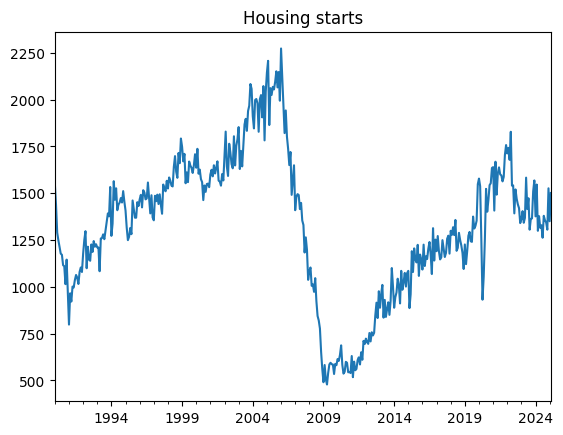

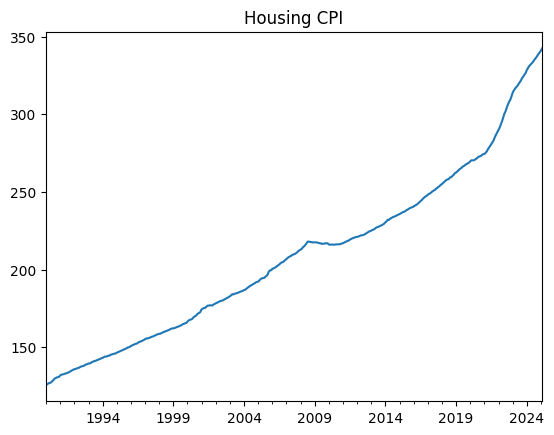

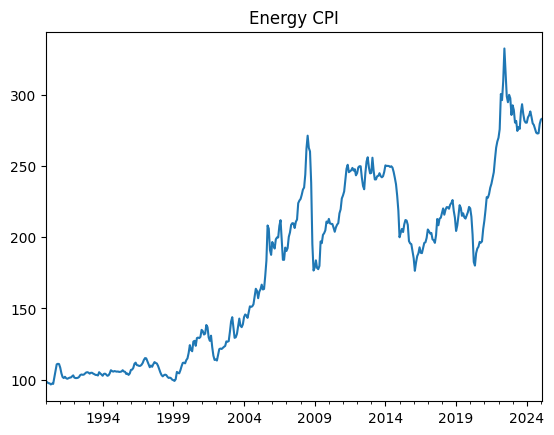

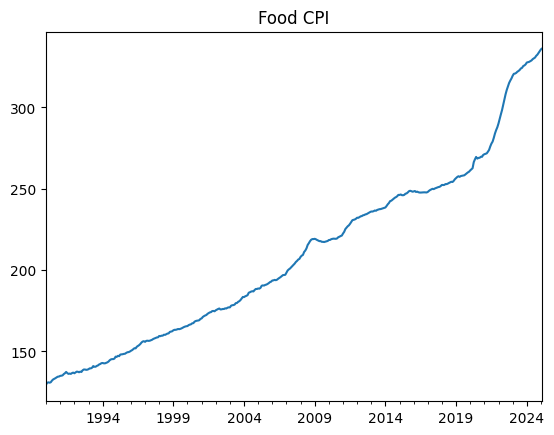

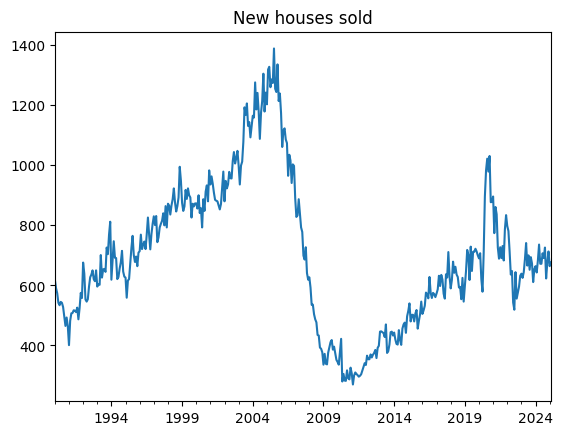

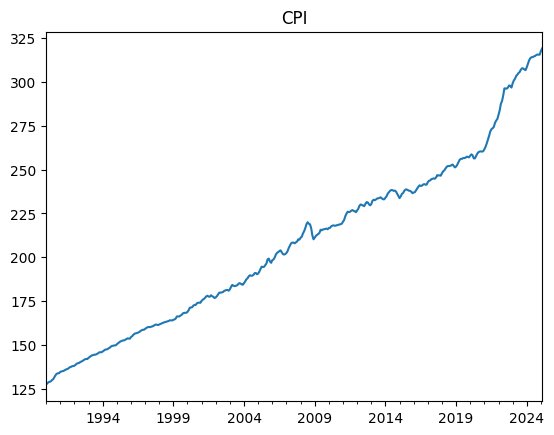

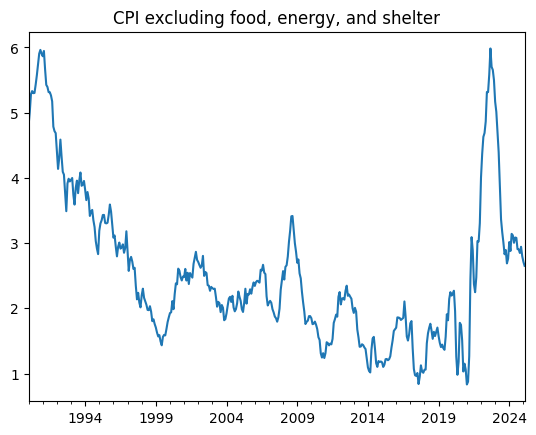

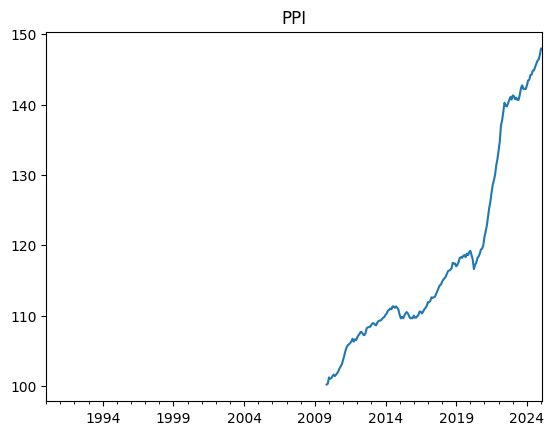

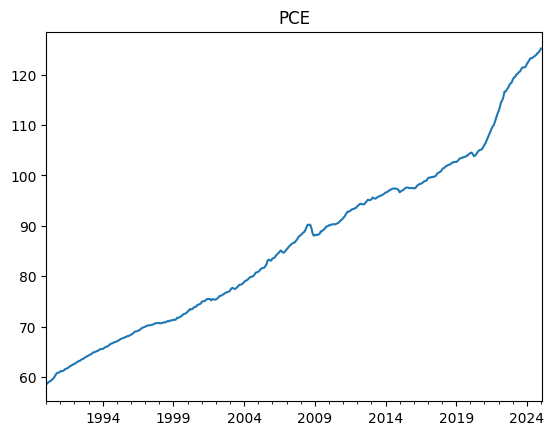

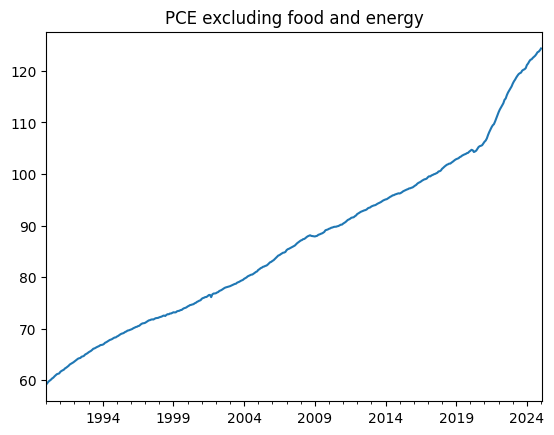

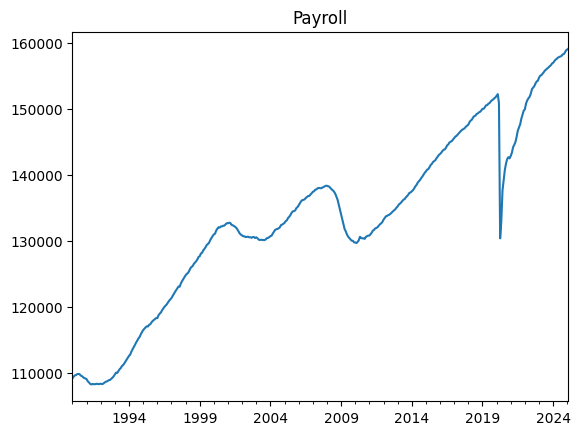

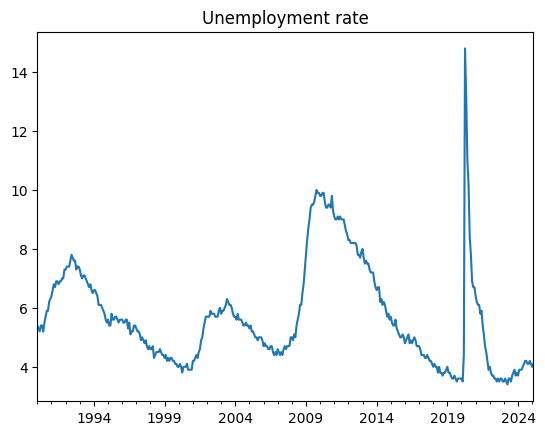

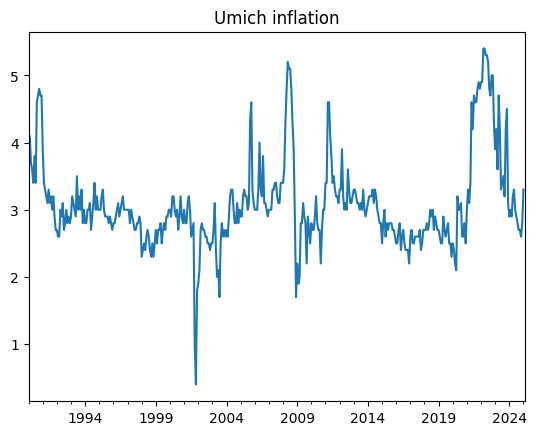

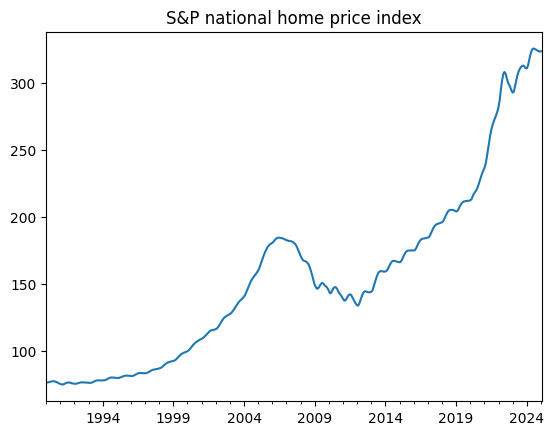

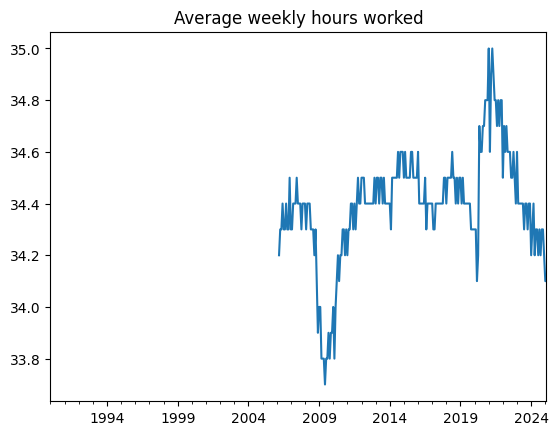

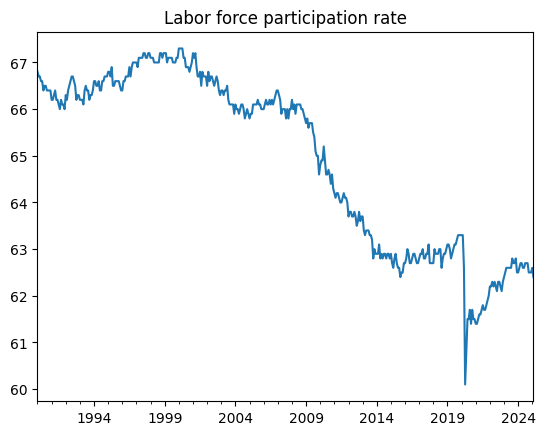

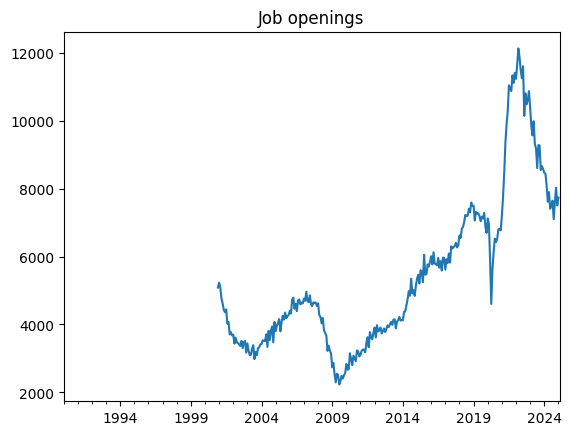

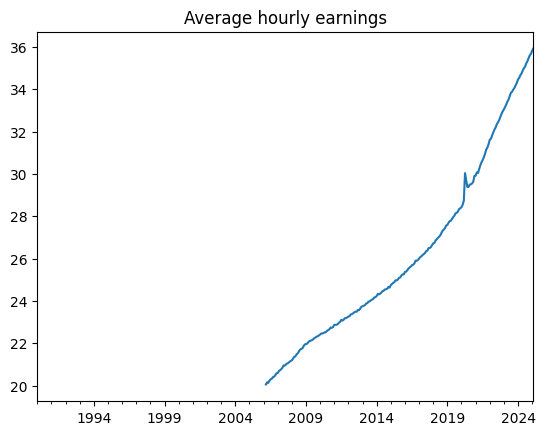

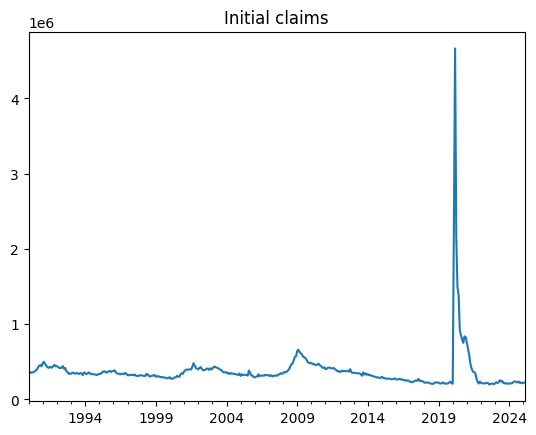

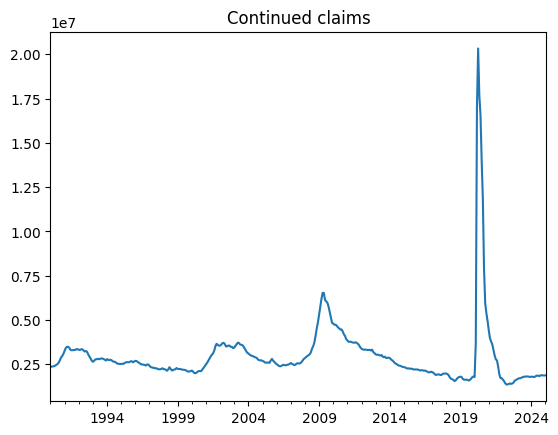

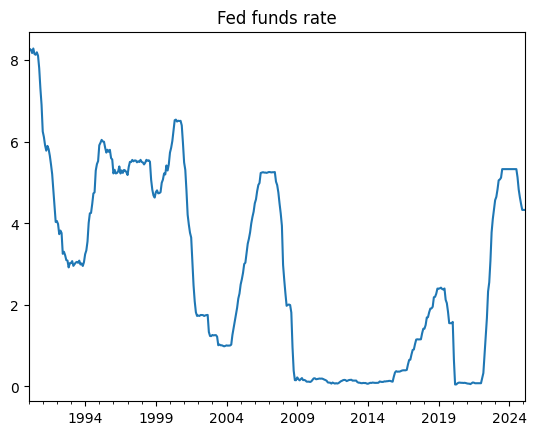

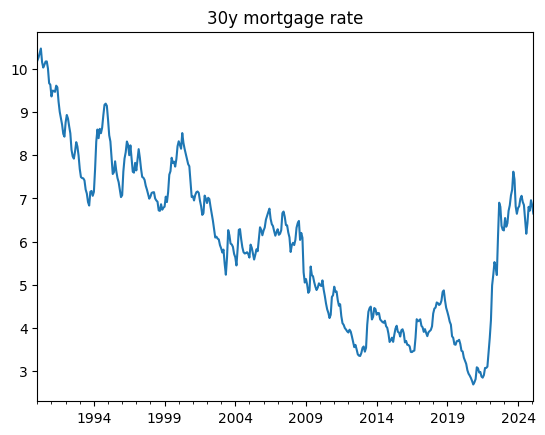

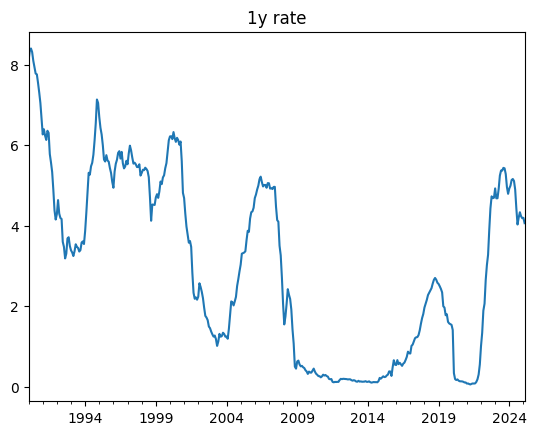

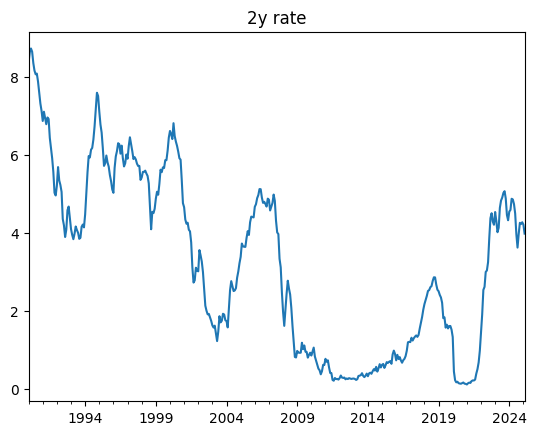

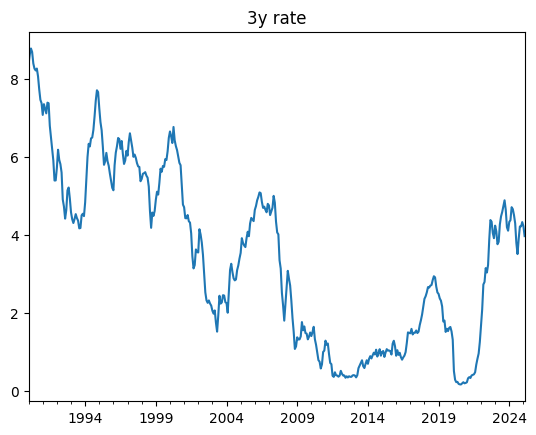

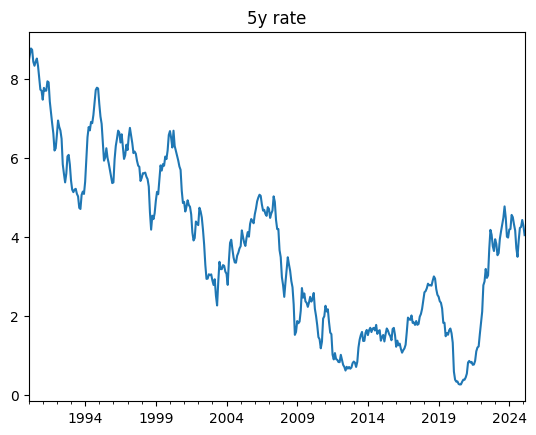

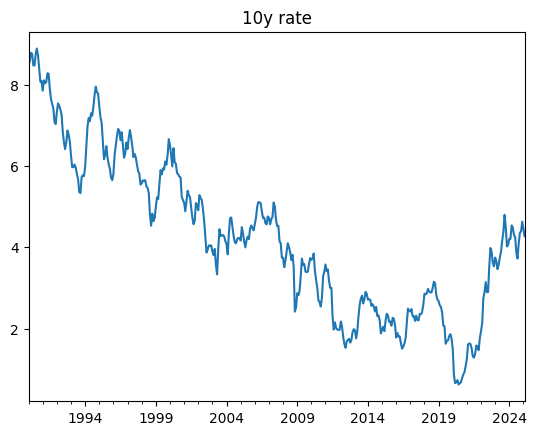

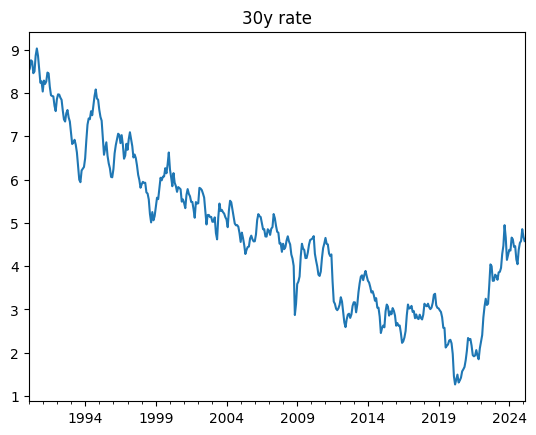

<Figure size 640x480 with 0 Axes>

In [107]:

#plot every variable to get a better look
for series in total_df:
  total_df[series].plot()
  plt.title(series)
  plt.show()
  plt.clf()

Log difference trending indices and average hourly earnings. Take first difference of payroll numbers (without logs), since we usually measure it as an absolute change month to month. Leave all other series as levels. Remove and print any columns whose number of observations is less than 75% of the total. Finally, remove any rows with NA values.

In [108]:
log_differenced_series = ["S&P national home price index", "PCE excluding food and energy", "PCE", "PPI", "CPI", "Food CPI", "Energy CPI", "Housing CPI", "Average hourly earnings"]
differenced_series = ["Payroll"]

for series in differenced_series:
  total_df[series] = total_df[series].diff(1)
for series in log_differenced_series:
  total_df[series] = 100*(total_df[series].apply(lambda x: math.log(x)).diff(1))

col_filter = total_df.count()>0.75*len(total_df)
retained_cols = col_filter[col_filter].index
total_df_long_hist = total_df[retained_cols].dropna(axis=0)
print("Columns removed by filter: ", [col for col in total_df.columns if col not in total_df_long_hist.columns], "\n")
print("Min date in filtered series: ", min(total_df_long_hist.index))
print("Max date in filtered series: ", max(total_df_long_hist.index))
print("Number of observations in series: ", len(total_df_long_hist.index))

total_df_long_hist.describe()


Columns removed by filter:  ['PPI', 'Average weekly hours worked', 'Job openings', 'Average hourly earnings'] 

Min date in filtered series:  1990-02-01 00:00:00
Max date in filtered series:  2025-01-01 00:00:00
Number of observations in series:  420


Housing starts  Housing CPI  Energy CPI    Food CPI  New houses sold  \
count      420.000000   420.000000  420.000000  420.000000       420.000000   
mean      1324.326190     0.236855    0.249881    0.226407       698.235714   
std        382.600449     0.167085    2.757668    0.251609       244.206961   
min        478.000000    -0.320015  -19.874963   -0.510764       270.000000   
25%       1090.250000     0.142426   -0.856500    0.069897       522.750000   
50%       1353.500000     0.221157    0.205476    0.191205       669.000000   
75%       1571.250000     0.308691    1.536417    0.347968       864.500000   
max       2273.000000     0.978989   12.628449    1.417058      1389.000000   

              CPI  CPI excluding food, energy, and shelter         PCE  \
count  420.000000                               420.000000  420.000000   
mean     0.217544                                 2.542445    0.180900   
std      0.338566                                 1.159287    0.198997   
min     -1.933869                                 0.832323   -1.187151   
25%      0.033490                                 1.763934    0.082147   
50%      0.202296                                 2.247508    0.174878   
75%      0.413249                                 3.011784    0.289780   
max      1.364259                                 5.983499    0.960448   

       PCE excluding food and energy       Payroll  ...  Initial claims  \
count                     420.000000    420.000000  ...    4.200000e+02   
mean                        0.176755    118.740476  ...    3.707814e+05   
std                         0.124408   1067.961740  ...    2.793353e+05   
min                        -0.569854 -20471.000000  ...    1.977500e+05   
25%                         0.103624     59.750000  ...    2.850250e+05   
50%                         0.161410    177.000000  ...    3.371250e+05   
75%                         0.231629    268.250000  ...    3.951250e+05   
max                         0.701702   4631.000000  ...    4.663250e+06   

       Continued claims  Fed funds rate  30y mortgage rate     1y rate  \
count      4.200000e+02      420.000000         420.000000  420.000000   
mean       2.965690e+06        2.822364           5.983286    2.958100   
std        1.881789e+06        2.337961           1.843461    2.278009   
min        1.359250e+06        0.049000           2.684000    0.050500   
25%        2.177625e+06        0.200887           4.247500    0.540868   
50%        2.602200e+06        2.404032           6.146250    2.662859   
75%        3.298625e+06        5.227152           7.200000    5.010238   
max        2.032640e+07        8.288667          10.477500    8.404500   

          2y rate     3y rate     5y rate    10y rate    30y rate  
count  420.000000  420.000000  420.000000  420.000000  420.000000  
mean     3.206273    3.390513    3.736800    4.231419    4.750686  
std      2.273089    2.218872    2.114229    1.945064    1.788596  
min      0.115263    0.158095    0.266667    0.623636    1.265238  
25%      0.928496    1.315305    1.792255    2.567976    3.128000  
50%      3.071500    3.368500    3.701833    4.146393    4.642641  
75%      5.001913    5.092549    5.400447    5.727643    5.941295  
max      8.724000    8.782500    8.768000    8.893158    9.028947  

[8 rows x 24 columns]

Test order of integration for each series. Most are I(0) or I(1). Since we are using an error correction model, we will not apply logs or differences to nonstationary series to make them stationary.

In [109]:

#in this section, test order of integration for each series in dataset
non_stationary_series = []
for series in total_df_long_hist.columns:
  if adfuller(total_df_long_hist[series][total_df_long_hist[series].notna()].values)[1]>0.01:
    non_stationary_series.append(series)



print("I(0) series in dataset: ", [series for series in total_df_long_hist.columns if series not in non_stationary_series], "\n")
#print("I(>0) series in dataset: ", non_stationary_series, "\n")


total_df_long_hist_first_diff = total_df_long_hist.diff(1).dropna()
order_one_series = []
for series in non_stationary_series:
  if adfuller(total_df_long_hist_first_diff[series].values)[1]<0.01:
   order_one_series.append(series)

print("I(1) series in dataset: ", order_one_series, "\n")

total_df_long_hist_second_diff = total_df[total_df.notna()].diff(1).diff(1).dropna()
order_two_series = []
for series in list(set(non_stationary_series)-set(order_one_series)):
  if adfuller(total_df_long_hist_second_diff[series].values)[1]<0.01:
    order_two_series.append(series)

print("I(2) series in dataset: ", order_two_series, "\n")
print("I(>2) series in dataset: ", list(set(non_stationary_series)-set(order_one_series)-set(order_two_series)))


I(0) series in dataset:  ['Housing CPI', 'Energy CPI', 'Food CPI', 'CPI', 'PCE', 'Payroll', 'Umich inflation', 'Initial claims', 'Continued claims', 'Fed funds rate'] 

I(1) series in dataset:  ['Housing starts', 'CPI excluding food, energy, and shelter', 'PCE excluding food and energy', 'Unemployment rate', 'S&P national home price index', 'Labor force participation rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate'] 

I(2) series in dataset:  ['New houses sold'] 

I(>2) series in dataset:  []


Above we manually segmented our series into [Rates, Housing, Prices, Employment]. Let's look for groupings scientifically and see what makes sense. Scale our time series to (0 mean, 1 var) and view each as a point in 419 dimensional space. Run K-means and examine distortion as a function of K, looking for elbow. Decide on k=4.

Distortion as function of k: 

1 : 327.0294668740642 

2 : 230.41813240843865 

3 : 191.64446482705296 

4 : 137.81203468984108 

5 : 146.88966403643067 

6 : 107.07224231721916 

7 : 89.7617982580074 

8 : 74.24475421300914 

9 : 60.426558449026864 

10 : 56.96607563075583 

11 : 41.41957503516631 

12 : 31.730561398927506 

13 : 21.5532864180863 

14 : 21.931648699996725 

15 : 13.483933334844714 

16 : 10.442091506543086 

17 : 4.2175076066796064 

18 : 3.005518842991272 

19 : 1.7360023991418092 

20 : 1.3826099860274865 

21 : 0.6929560974988069 

22 : 0.49112944476976717 

23 : 0.06920016537845787 

24 : 5.476104956006872e-31 



Text(0.5, 1.0, 'Distortion as function of K')

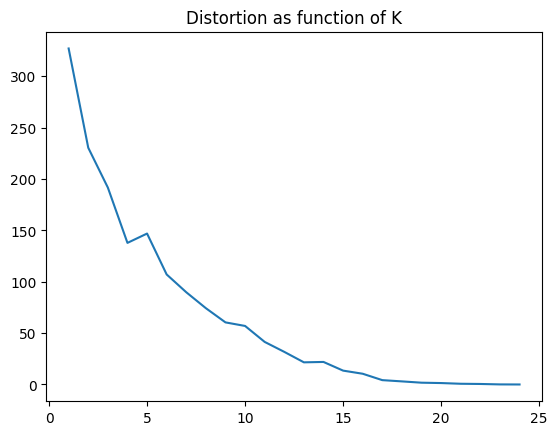

In [116]:
scaler = StandardScaler()
data_scaled = pd.DataFrame(index = total_df_long_hist.index, columns = total_df_long_hist.columns, data =scaler.fit_transform(total_df_long_hist))

distortion=[]
k_to_clusters = {}
K = [k+1 for k in range(24)]
for k in K:

  kmeansmodel = KMeans(n_clusters=k).fit(data_scaled.T)
  distortion.append(sum(np.min(cdist(data_scaled.T, kmeansmodel.cluster_centers_, 'euclidean'), axis=1)**2) / data_scaled.T.shape[0])
  predictions = kmeansmodel.predict(data_scaled.T)
  var_to_group = dict(zip(data_scaled.columns, predictions))
  group_to_vars = {}
  for key, value in var_to_group.items():
    group_to_vars[value] = group_to_vars.get(value, []) + [key]
  k_to_clusters[k]=group_to_vars


print("Distortion as function of k: \n")
for k in K:
  print(k, ":", distortion[k-1], "\n")
plt.plot([k+1 for k in range(len(K))], distortion)
plt.title("Distortion as function of K")




First cluster is a housing cluster. Second is a prices cluster, with the interesting addition of payroll. Third is a rates cluster with the addition of labor force participation and CPI excluding food/energy/shelter. Fourth is an (un)employment cluster

In [117]:

print(k_to_clusters[4])

{np.int32(3): ['Housing starts', 'New houses sold', 'S&P national home price index'], np.int32(2): ['Housing CPI', 'Energy CPI', 'Food CPI', 'CPI', 'PCE', 'PCE excluding food and energy', 'Payroll', 'Umich inflation'], np.int32(1): ['CPI excluding food, energy, and shelter', 'Labor force participation rate', 'Fed funds rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate'], np.int32(0): ['Unemployment rate', 'Initial claims', 'Continued claims']}


Try hierarchical clustering with cosine similarity to get a second opinion. After looking at dendrogram, estimate that there are four clusters (strictly speaking, the dednrogram shows 2 or 3, but the split with 4 gives the most reasonable results)

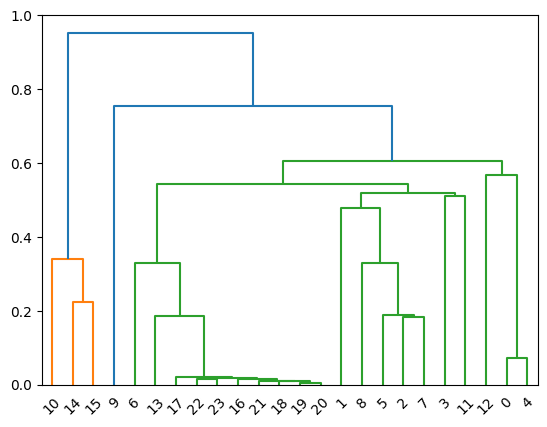

In [118]:
similarity_matrix =np.zeros((len(data_scaled.columns), len(data_scaled.columns)))
for i in range(len(data_scaled.columns)):
  col1 = data_scaled.columns[i]
  norm1 = np.linalg.norm(data_scaled[col1].values.reshape(-1, 1))
  for j in range(len(data_scaled.columns)):
    col2 = data_scaled.columns[j]
    norm2 = np.linalg.norm(data_scaled[col2].values.reshape(-1, 1))
    dot_prod = np.dot(data_scaled[col1].values, data_scaled[col2].values)
    cos = dot_prod/(norm1*norm2)
    if i == j:
      similarity_matrix[i, j] =0
    else:
      similarity_matrix[i, j] = 1-cos
dists = squareform(similarity_matrix)
shc.dendrogram((linkage(dists)))
plt.show()

Print the clusters. Notice that the (un)employment cluster is the same as from k-means. We also see a clear rates cluster. Unlike K-means, the other two clusters show less resolution between housing and prices.

In [119]:
agglom_model = AgglomerativeClustering(metric='precomputed', n_clusters=4, linkage='complete').fit(similarity_matrix)
agglom_var_to_group = dict(zip(data_scaled.columns, agglom_model.labels_))
agglom_group_to_vars = {}
for key, value in agglom_var_to_group.items():
  agglom_group_to_vars[value] = agglom_group_to_vars.get(value, []) + [key]
print(agglom_group_to_vars)





{np.int64(0): ['Housing starts', 'Energy CPI', 'New houses sold', 'CPI', 'PCE', 'Payroll', 'S&P national home price index'], np.int64(2): ['Housing CPI', 'Food CPI', 'CPI excluding food, energy, and shelter', 'PCE excluding food and energy', 'Umich inflation'], np.int64(1): ['Unemployment rate', 'Initial claims', 'Continued claims'], np.int64(3): ['Labor force participation rate', 'Fed funds rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate']}


One more method: try DBSCAN on the cosine similarity matrix. Use grid search to find best parameters.

In [120]:
epsilon_choices = np.linspace(0.01, 5, num=1500)
minpts_choices = np.arange(3, 25)
best_model = None
best_model_score = -100000000
best_eps = None
best_minpts = None

for epsilon in epsilon_choices:
  for minpt in minpts_choices:
    model = DBSCAN(eps=epsilon, min_samples=minpt, metric="precomputed")
    model.fit(similarity_matrix)
    labels = set(model.labels_)
    if len(labels)<2 or len(labels)>similarity_matrix.shape[0]:
      continue
    score = shs(similarity_matrix, model.labels_)
    if score>best_model_score:
      best_model_score=score
      best_model = model
      best_eps = epsilon
      best_minpts = minpt
print("Best epsilon: ", best_eps)
print("Best minpts: ", best_minpts)
var_to_group_dbscan = dict(zip(data_scaled.columns, best_model.labels_))
group_to_vars_dbscan = {}
for key, value in var_to_group_dbscan.items():
  group_to_vars_dbscan[value] = group_to_vars_dbscan.get(value, []) + [key]


Best epsilon:  0.5193195463642428
Best minpts:  3


Let's look at the result from K-means with k=4 and DBSCAN. They are strikingly similar. Only difference: DBSCAN puts Payroll in the housing cluster, while k-means puts it with the inflation data. Otherwise, they are identical. On the margin I prefer lumping in payroll with the inflation series, so we will use that clustering in our VECM model for predictions.

In [122]:
print("K-means clusters with k=4: ", k_to_clusters[4], "\n")
print("DBSCAN clusters from cosine similarity matrix: ", group_to_vars_dbscan, "\n")

K-means clusters with k=4:  {np.int32(3): ['Housing starts', 'New houses sold', 'S&P national home price index'], np.int32(2): ['Housing CPI', 'Energy CPI', 'Food CPI', 'CPI', 'PCE', 'PCE excluding food and energy', 'Payroll', 'Umich inflation'], np.int32(1): ['CPI excluding food, energy, and shelter', 'Labor force participation rate', 'Fed funds rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate'], np.int32(0): ['Unemployment rate', 'Initial claims', 'Continued claims']} 

DBSCAN clusters from cosine similarity matrix:  {np.int64(-1): ['Housing starts', 'New houses sold', 'Payroll', 'S&P national home price index'], np.int64(0): ['Housing CPI', 'Energy CPI', 'Food CPI', 'CPI', 'PCE', 'PCE excluding food and energy', 'Umich inflation'], np.int64(1): ['CPI excluding food, energy, and shelter', 'Labor force participation rate', 'Fed funds rate', '30y mortgage rate', '1y rate', '2y rate', '3y rate', '5y rate', '10y rate', '30y rate'], np.int64(2)

Overall, I think K-means with k = 4 gave the most reasonable clusters. Group the data into those four clusters and dimension reduce each cluster with PCA such that >90% of the variance in each cluster is explained. We will pass these new latent variables to our VECM model. I name the clusters by their general theme.

Housing explained var ratios: ,  [0.7379168  0.23809763] 

Series in Housing group:  ['S&P national home price index', 'Housing starts', 'New houses sold'] 



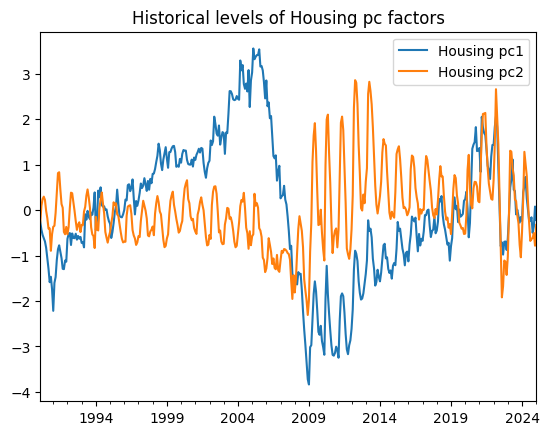

Prices explained var ratios: ,  [0.46252727 0.17976536 0.12816404 0.08415322 0.06465615] 

Series in Prices group:  ['Housing CPI', 'PCE excluding food and energy', 'Energy CPI', 'CPI', 'Food CPI', 'Payroll', 'Umich inflation', 'PCE'] 



<Figure size 640x480 with 0 Axes>

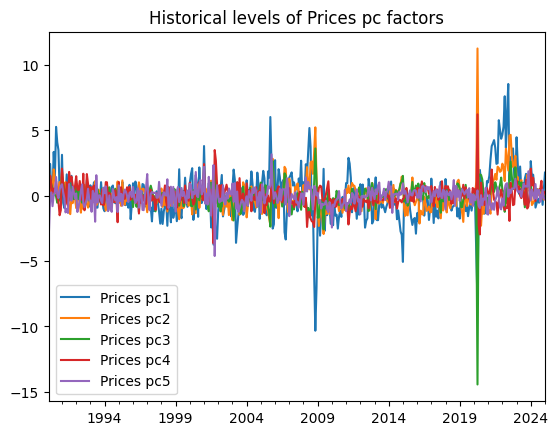

Rates explained var ratios: ,  [0.84379189 0.07688534] 

Series in Rates group:  ['1y rate', '30y mortgage rate', '10y rate', 'Fed funds rate', '2y rate', 'Labor force participation rate', '30y rate', '5y rate', '3y rate', 'CPI excluding food, energy, and shelter'] 



<Figure size 640x480 with 0 Axes>

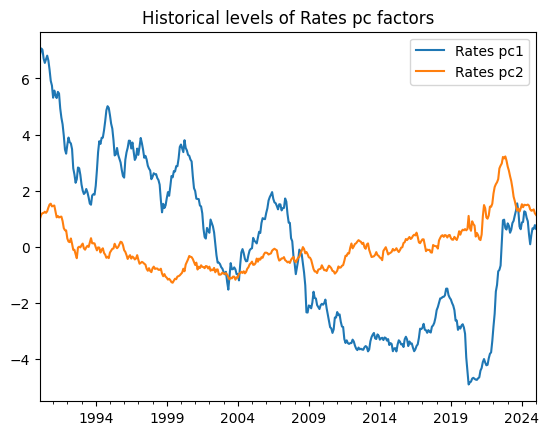

Unemployment explained var ratios: ,  [0.73400712 0.2218548 ] 

Series in Unemployment group:  ['Continued claims', 'Unemployment rate', 'Initial claims'] 



<Figure size 640x480 with 0 Axes>

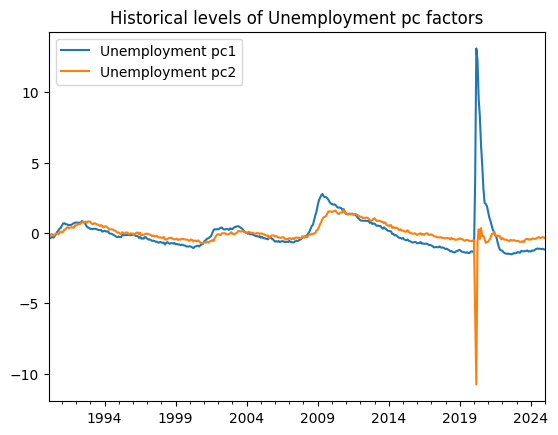

<Figure size 640x480 with 0 Axes>

In [123]:

pca_object_dict = {}
pca_component_dict = {}
scaler_dict = {}

#define our groups from k-means with k=4
group_to_series = {"Housing": k_to_clusters[4][3], "Prices": k_to_clusters[4][2], "Rates": k_to_clusters[4][1], "Unemployment": k_to_clusters[4][0]}

series_to_group = {}
for title, group in group_to_series.items():
  for series in group:
    series_to_group[series]=title


#run pca on each of the econ data groups from k-means.
for title, group in group_to_series.items():


  applicable_cols = list(set(group)&set(total_df_long_hist.columns))
  this_group_series = total_df_long_hist[applicable_cols].copy()
  scaler = StandardScaler()


  this_group_series_stand = scaler.fit_transform(this_group_series)

  pca = PCA(n_components = 0.9, svd_solver="full")
  transformed_data = pca.fit_transform(this_group_series_stand)
  pca_component_dict[title] = pd.DataFrame(pca.components_,columns=this_group_series.columns,index = ["pc"+str(k+1) for k in range(len(pca.components_))])
  pca_object_dict[title] = pca
  scaler_dict[title] = scaler
  for k in range(len(pca.components_)):
    total_df_long_hist[title+" pc"+str(k+1)] = transformed_data[:, k]


  print(title +" explained var ratios: , ", pca.explained_variance_ratio_, "\n")
  print("Series in "+title+" group: ", applicable_cols, "\n")
  total_df_long_hist[[series for series in total_df_long_hist if title+" pc" in series]].plot()
  plt.title("Historical levels of "+title+" pc factors")
  plt.show()
  plt.clf()



Now, we're curious how well the PCs explain each variable in the original space. We will look back on this later after making predictions, since poor prediction quality on a variable in the original space may be a sign that the dimension reduction crushes variance from that variable. Points to note: the five series whose residuals against their group's PC factors do not mean revert are unemployment, initial claims, continuing claims, 1y rate, and 30y rate.





Target variable:  Housing starts 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 244.21043630185798, 'Housing pc2': -110.14331842637606} 

R2:  0.9634071977828044 

Residuals pass mean reversion test?  True 



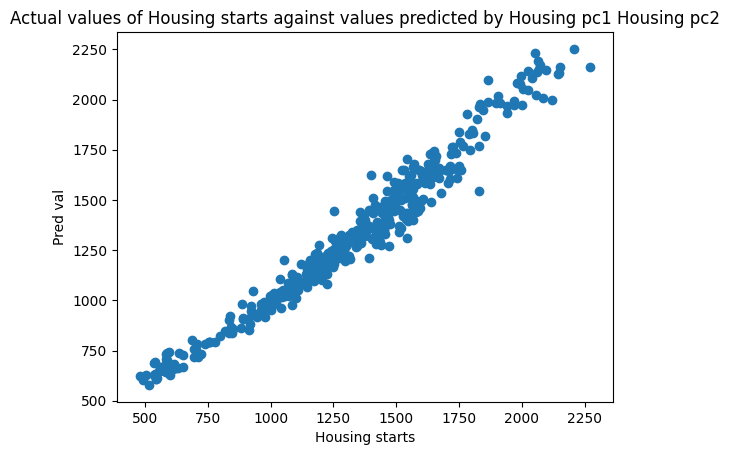

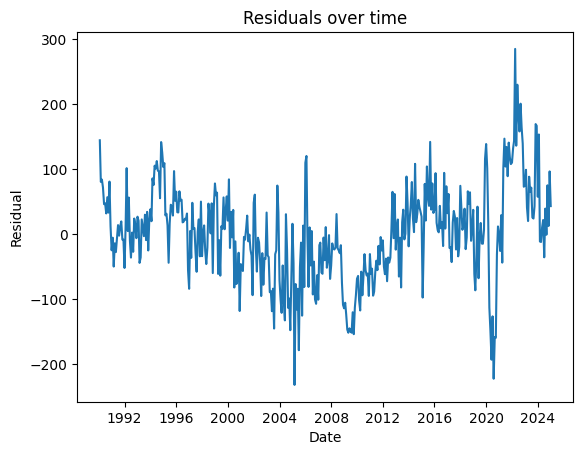





Target variable:  Housing CPI 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.060339803576725026, 'Prices pc2': 0.03887764522675795, 'Prices pc3': 0.030673444678386664, 'Prices pc4': 0.05548300967971791, 'Prices pc5': 0.11814444392168634} 

R2:  0.9300485960255769 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

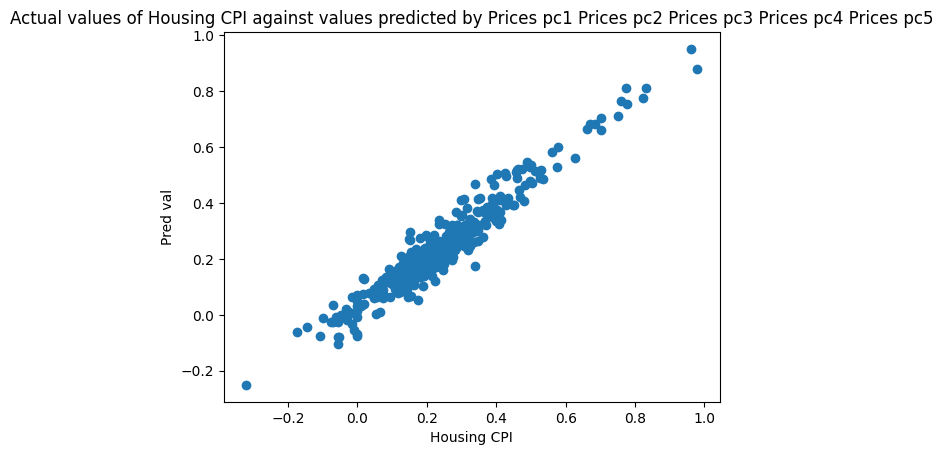

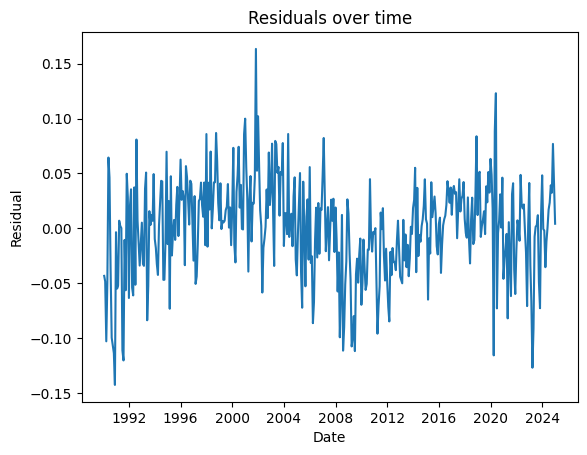





Target variable:  Energy CPI 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 1.0142613595825378, 'Prices pc2': -1.2312088867546525, 'Prices pc3': -1.00895077691052, 'Prices pc4': -0.46925283727734585, 'Prices pc5': 0.2771775808825321} 

R2:  0.9514451308419797 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

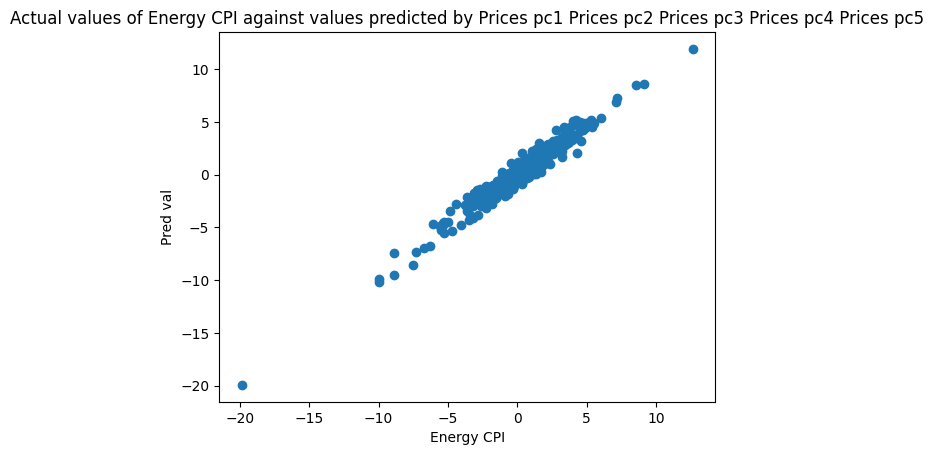

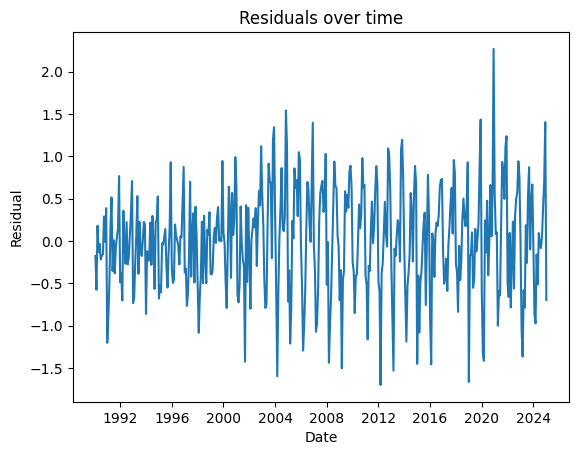





Target variable:  Food CPI 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.0538804209595732, 'Prices pc2': 0.14842163323842492, 'Prices pc3': -0.055700514233109955, 'Prices pc4': -0.09434932283089567, 'Prices pc5': -0.09336383893785476} 

R2:  0.8883516436400138 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

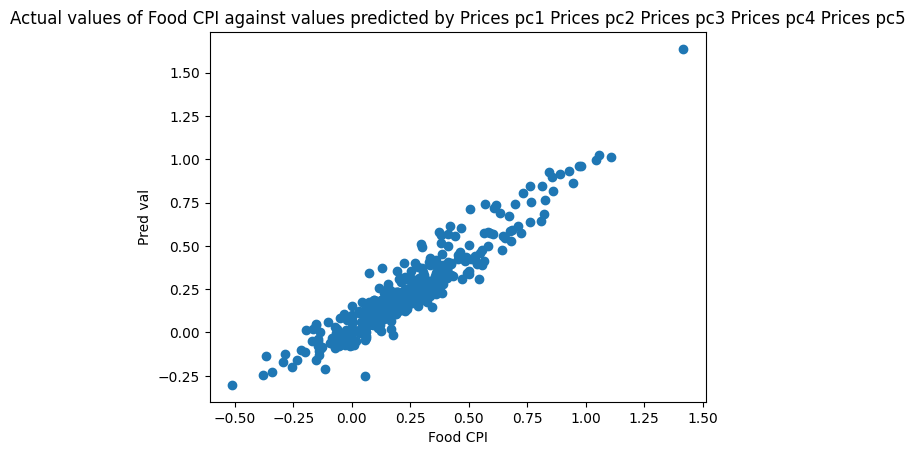

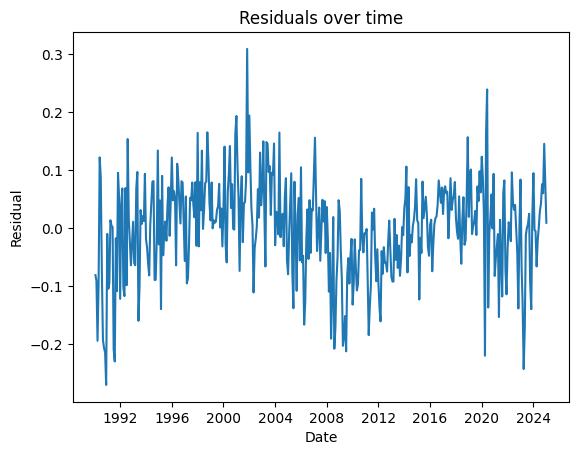





Target variable:  New houses sold 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 154.4072875020461, 'Housing pc2': -80.38067674242392} 

R2:  0.9646930590659984 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

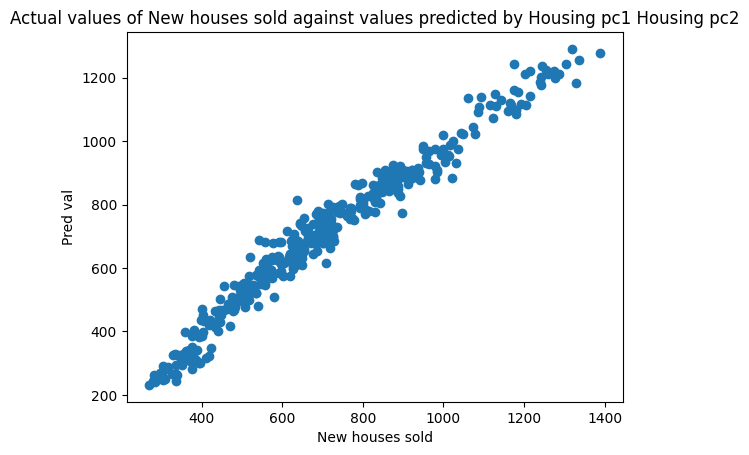

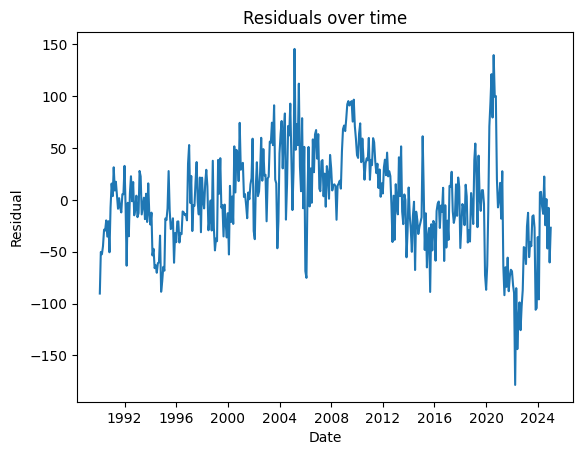





Target variable:  CPI 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.14677147830575865, 'Prices pc2': -0.07719786031346687, 'Prices pc3': -0.09034490418424997, 'Prices pc4': -0.007338184184300748, 'Prices pc5': -0.007781591392123657} 

R2:  0.845764749679796 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

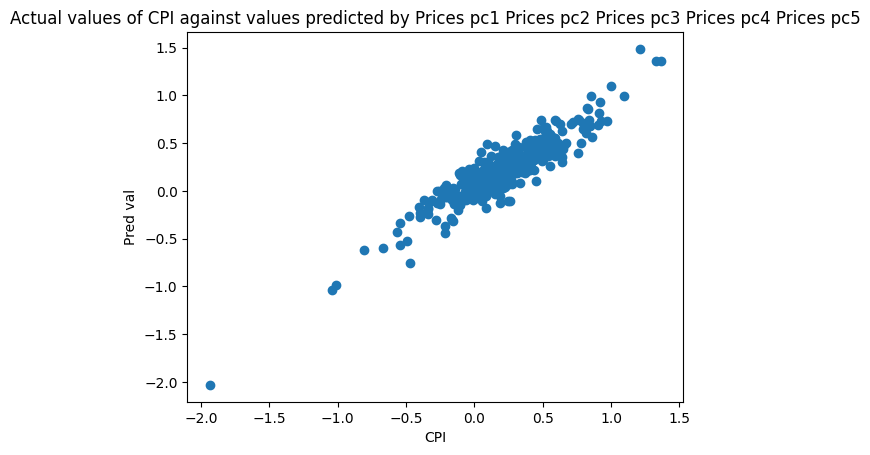

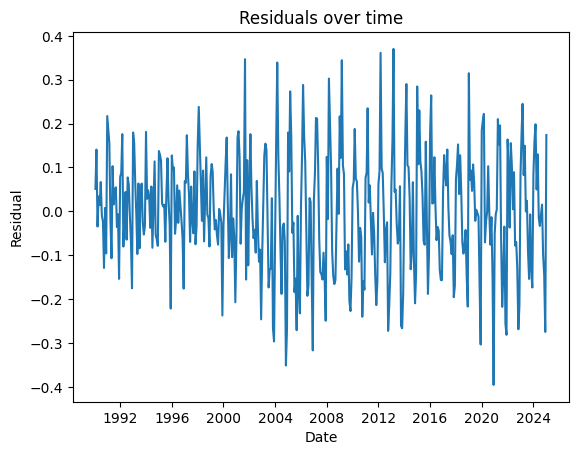





Target variable:  CPI excluding food, energy, and shelter 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.2609969854043419, 'Rates pc2': 0.7790710224296089} 

R2:  0.7767637104096726 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

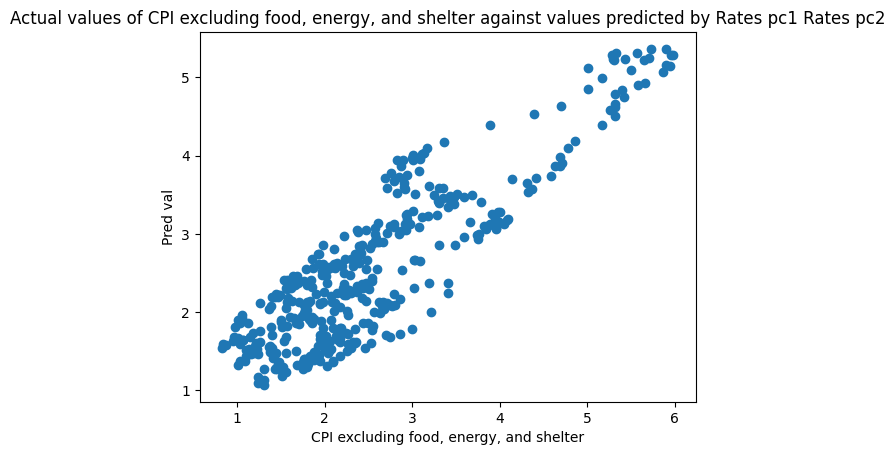

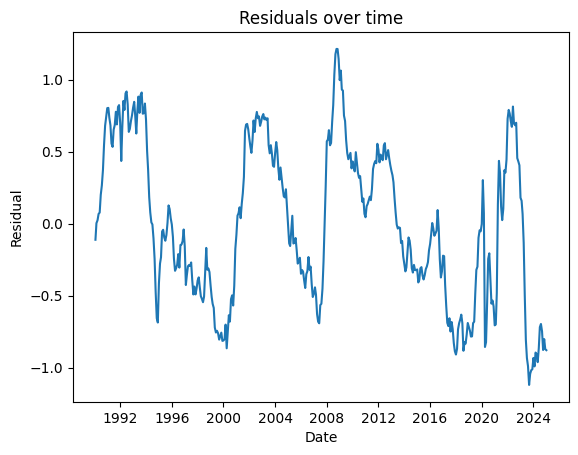





Target variable:  PCE 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.09693251322604886, 'Prices pc2': -0.031467780767967406, 'Prices pc3': -0.02560045967360719, 'Prices pc4': 0.027547045329505, 'Prices pc5': -0.044830040166880775} 

R2:  0.9723538271943876 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

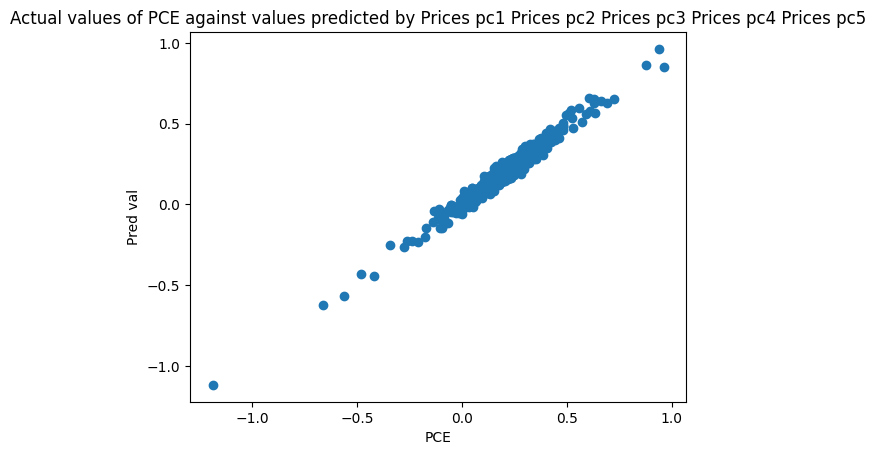

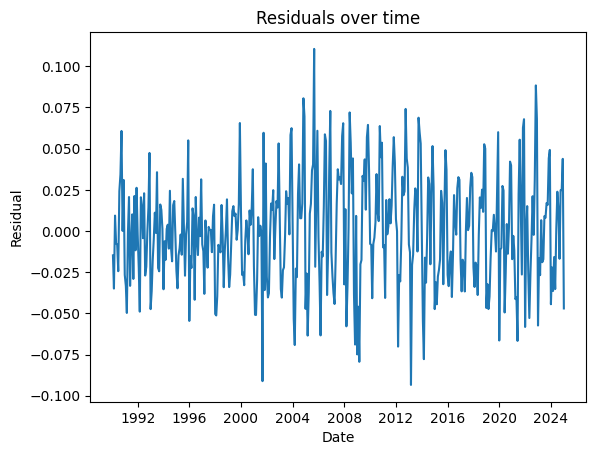





Target variable:  PCE excluding food and energy 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.045020554768791694, 'Prices pc2': 0.018405795528036485, 'Prices pc3': 0.05191220864850297, 'Prices pc4': 0.06296661172463468, 'Prices pc5': -0.05893677542099111} 

R2:  0.9854608794806508 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

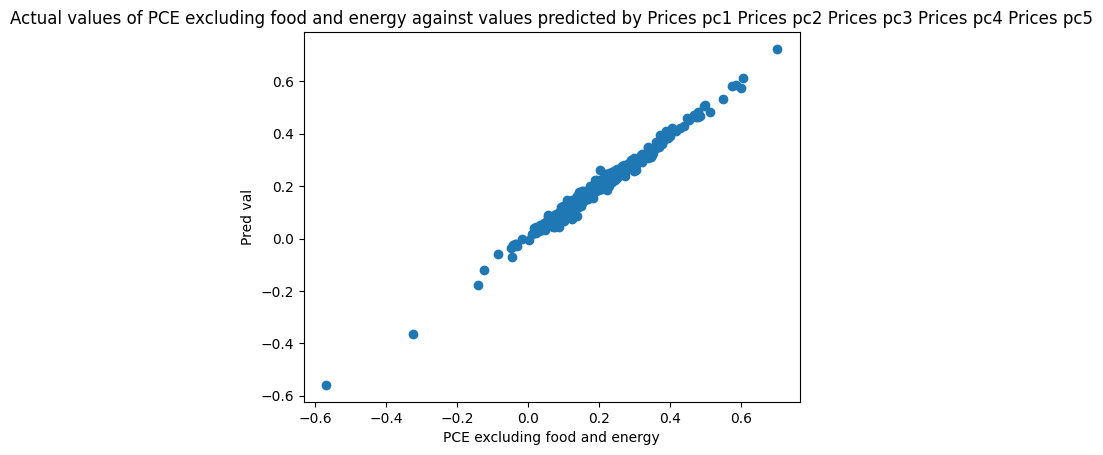

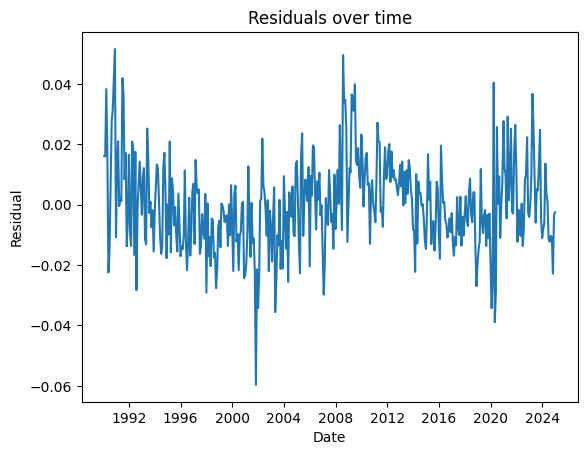





Target variable:  Payroll 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 155.85538439106347, 'Prices pc2': -399.3788621620935, 'Prices pc3': 758.8854957185965, 'Prices pc4': -529.9624931425767, 'Prices pc5': -66.48520357259247} 

R2:  0.9677402666870094 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

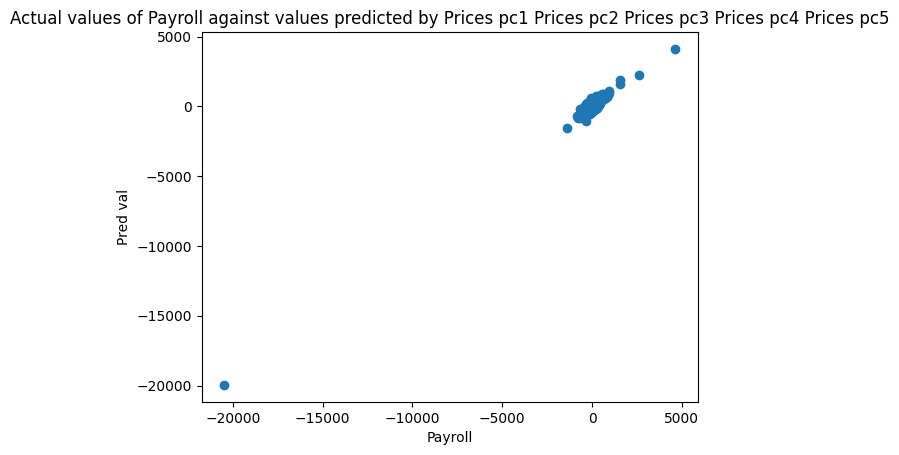

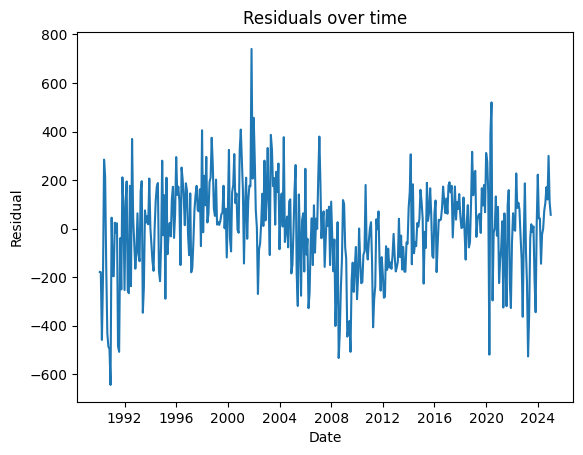





Target variable:  Unemployment rate 

Regressors:  Unemployment pc1 Unemployment pc2 

Coefficients:  {'Unemployment pc1': 0.899833818679582, 'Unemployment pc2': 1.3531525930763197} 

R2:  0.9819791525799813 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

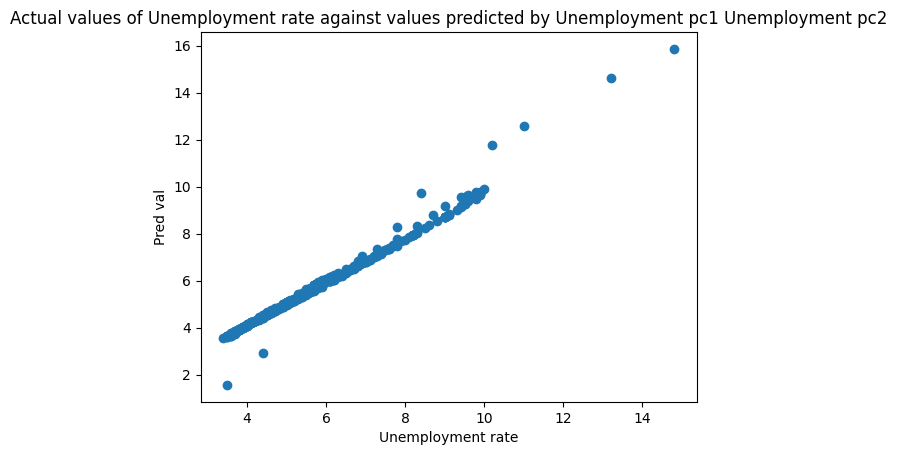

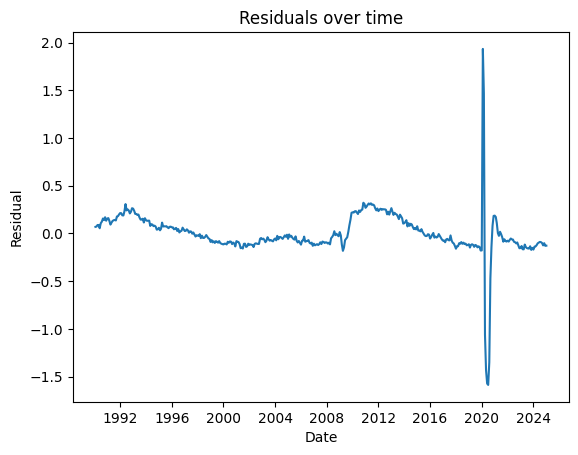





Target variable:  Umich inflation 

Regressors:  Prices pc1 Prices pc2 Prices pc3 Prices pc4 Prices pc5 

Coefficients:  {'Prices pc1': 0.22270873608515887, 'Prices pc2': 0.26813527742390647, 'Prices pc3': 0.08061594060435444, 'Prices pc4': -0.2989674539896805, 'Prices pc5': 0.1791262283531258} 

R2:  0.8129631955028324 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

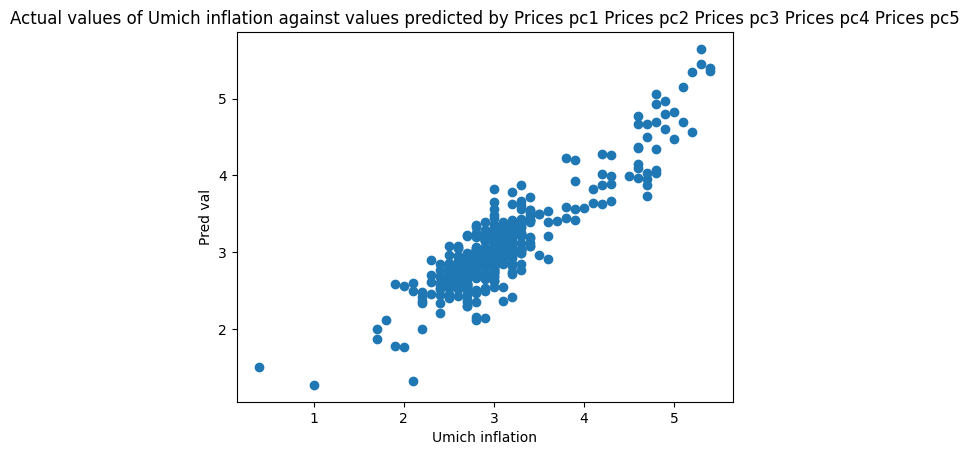

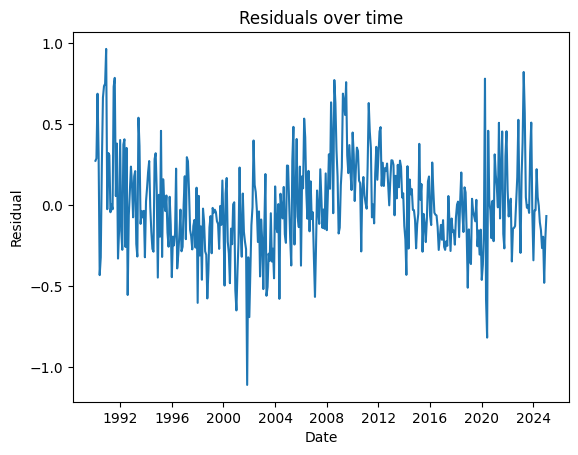





Target variable:  S&P national home price index 

Regressors:  Housing pc1 Housing pc2 

Coefficients:  {'Housing pc1': 0.31108874990803737, 'Housing pc2': 0.640174908948835} 

R2:  0.9999430245070222 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

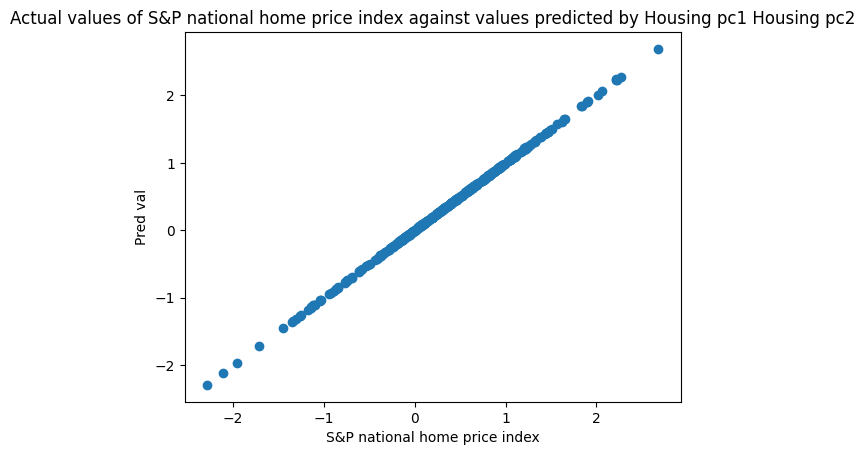

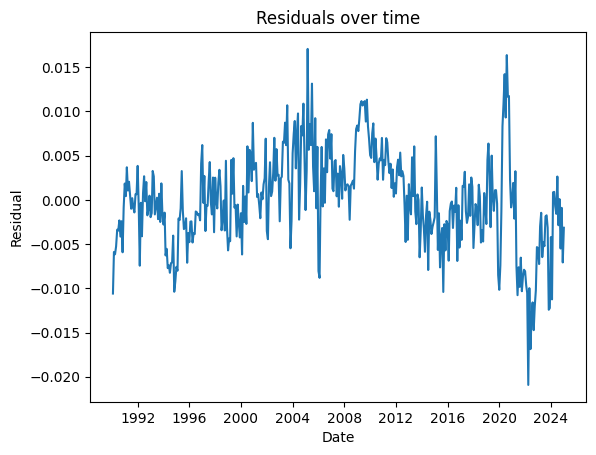





Target variable:  Labor force participation rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.4825910839062688, 'Rates pc2': -1.2353450338017178} 

R2:  0.9026343543140798 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

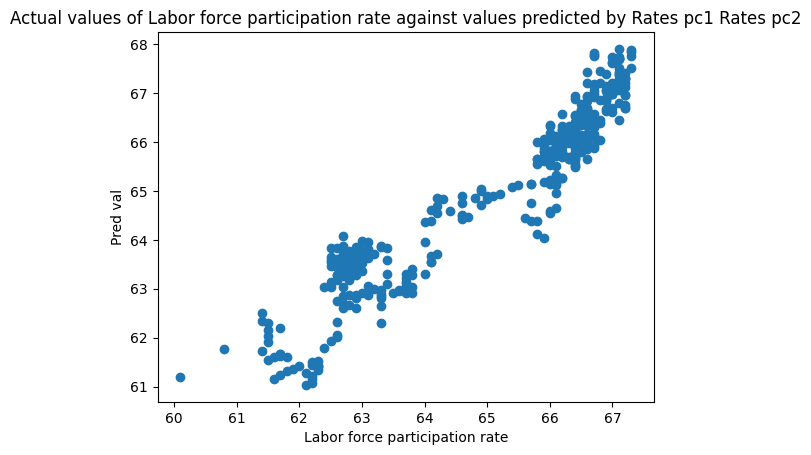

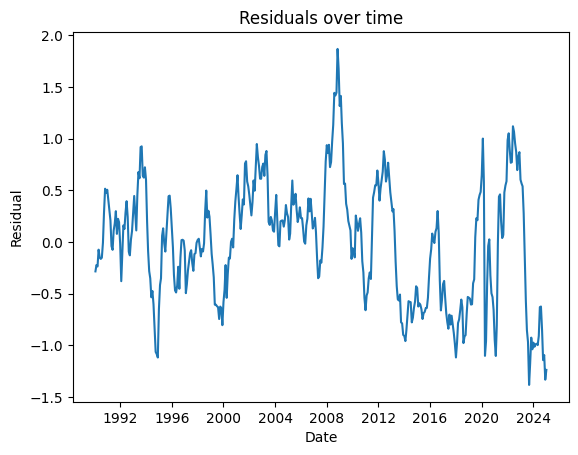





Target variable:  Initial claims 

Regressors:  Unemployment pc1 Unemployment pc2 

Coefficients:  {'Unemployment pc1': 157107.95443606918, 'Unemployment pc2': -175659.77994630267} 

R2:  0.9620610861757048 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

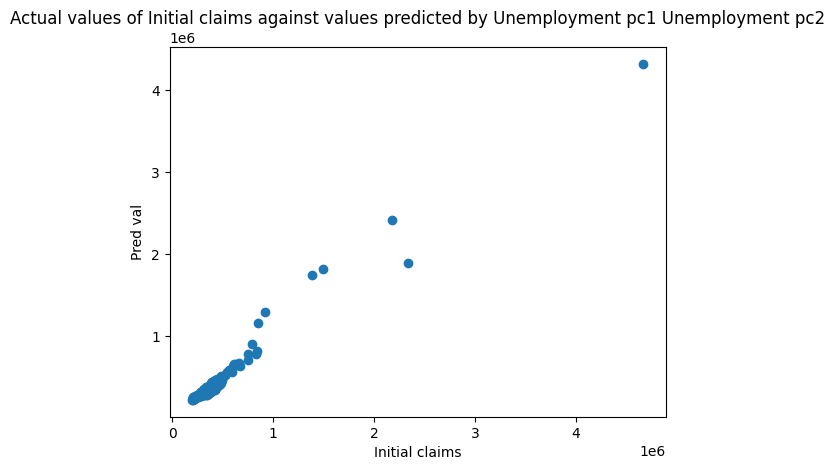

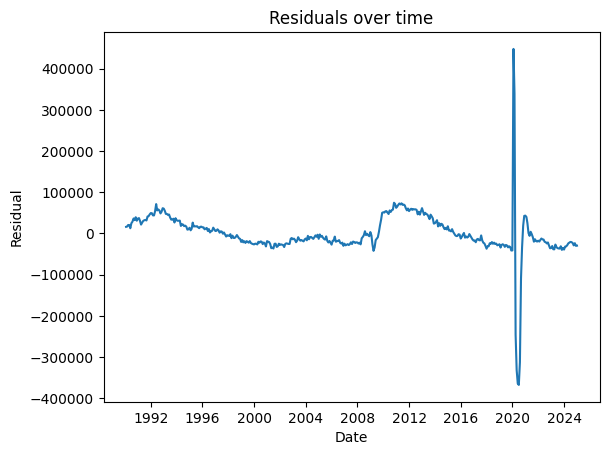





Target variable:  Continued claims 

Regressors:  Unemployment pc1 Unemployment pc2 

Coefficients:  {'Unemployment pc1': 1215212.2860800857, 'Unemployment pc2': -127352.21820410585} 

R2:  0.9235455451211521 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

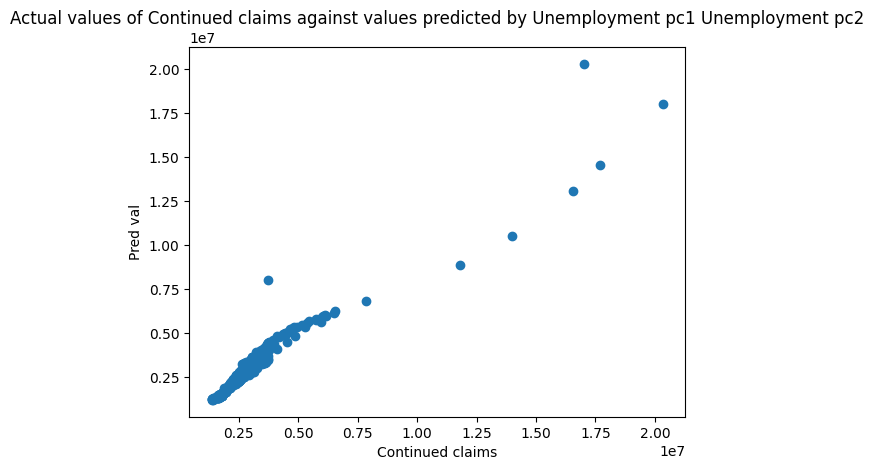

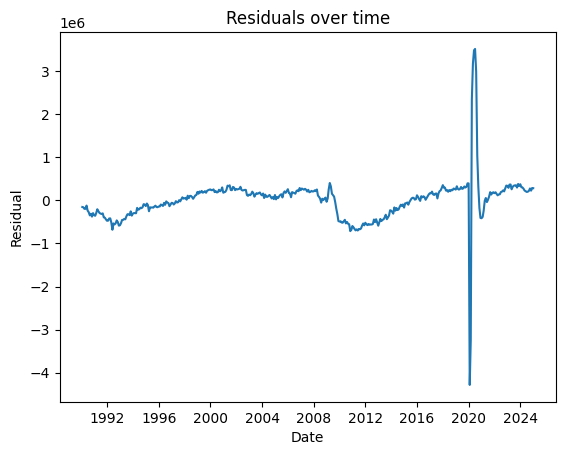





Target variable:  Fed funds rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.7381480074298772, 'Rates pc2': 0.294923597705589} 

R2:  0.8553710753457522 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

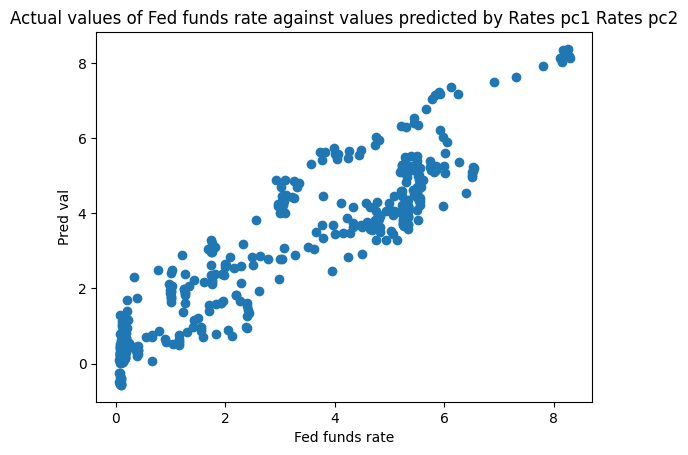

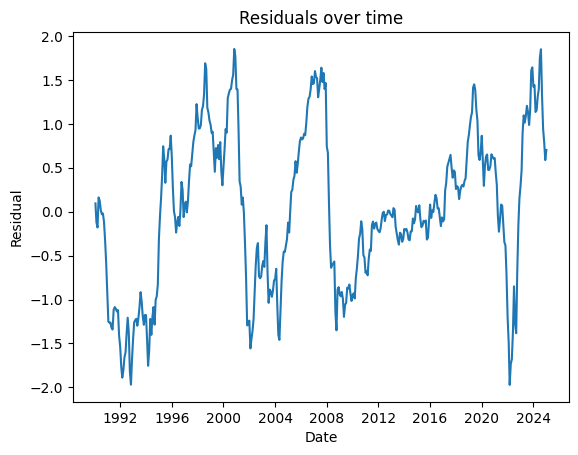





Target variable:  30y mortgage rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.6230654658680209, 'Rates pc2': -0.03571040941199635} 

R2:  0.96649572893462 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

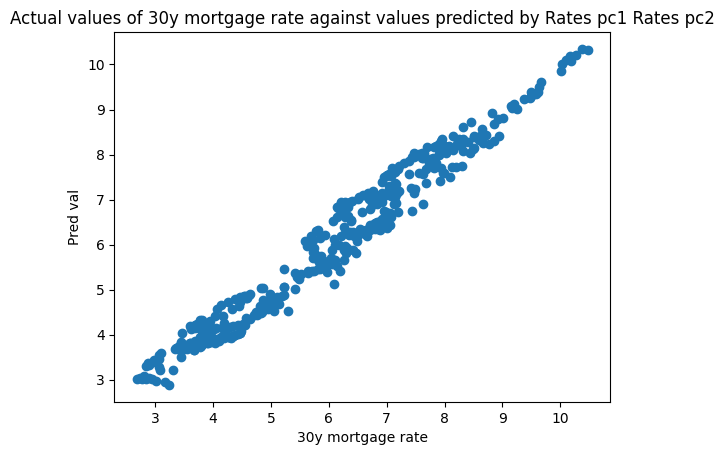

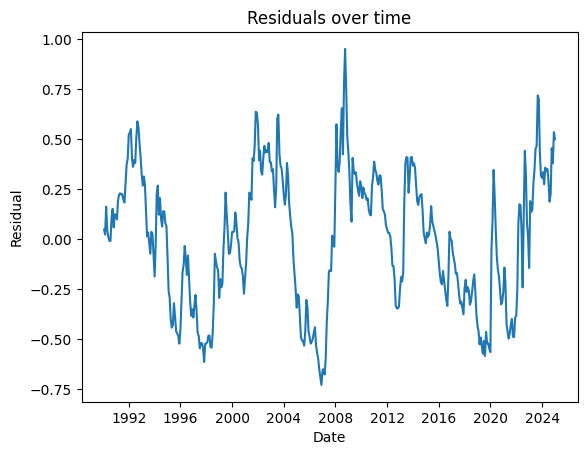





Target variable:  1y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.7420039294183708, 'Rates pc2': 0.3466977673148428} 

R2:  0.9152225122120835 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

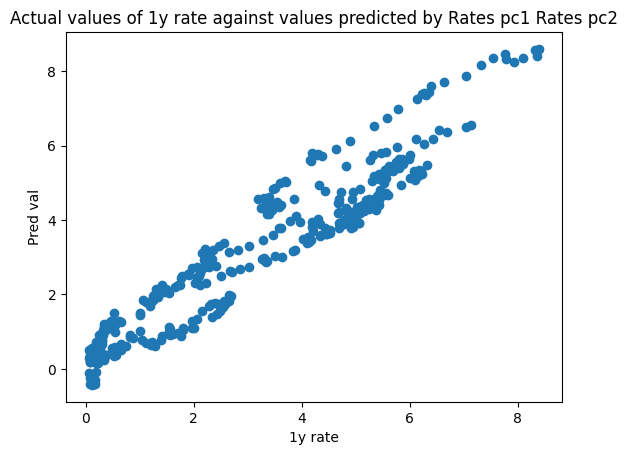

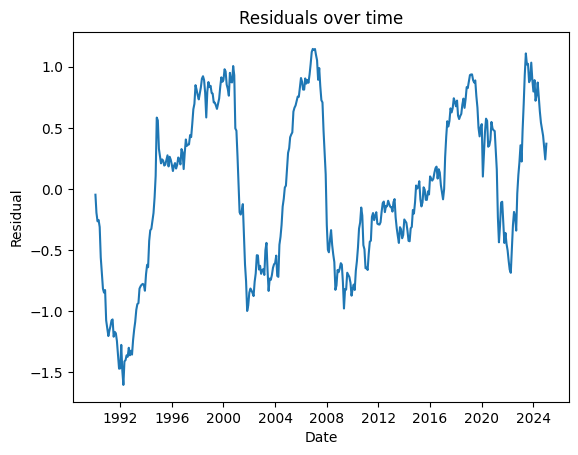





Target variable:  2y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.7620448045619872, 'Rates pc2': 0.21664974211182292} 

R2:  0.9576034679194868 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

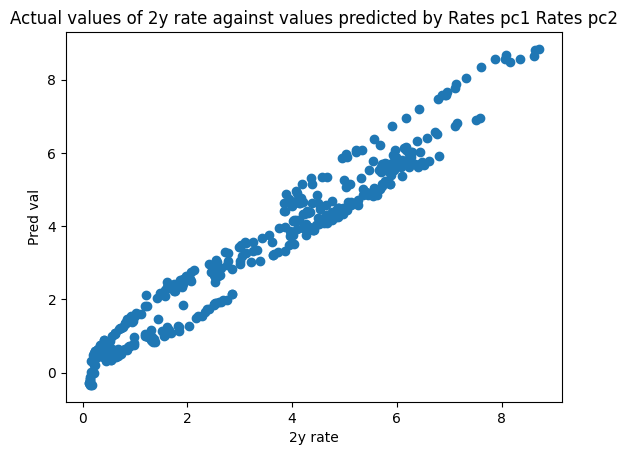

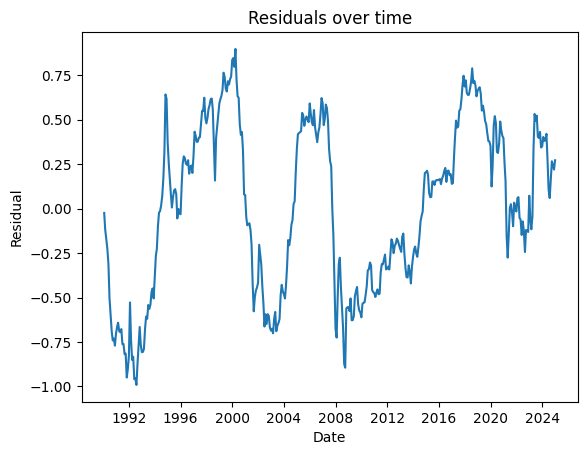





Target variable:  3y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.7530185581150544, 'Rates pc2': 0.11821959929913493} 

R2:  0.9763186859781946 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

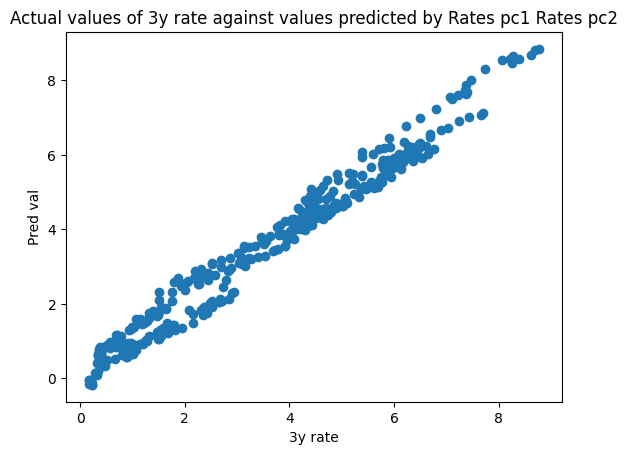

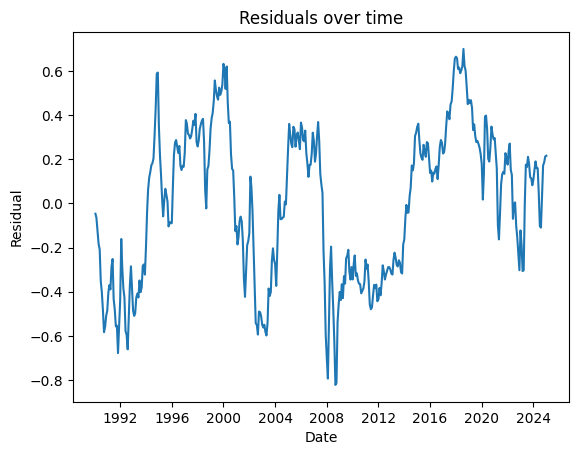





Target variable:  5y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.7225879514825893, 'Rates pc2': -0.04499728187267251} 

R2:  0.9883287606695446 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

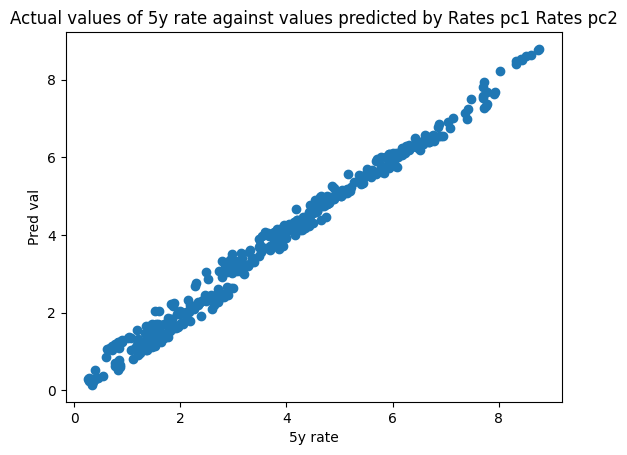

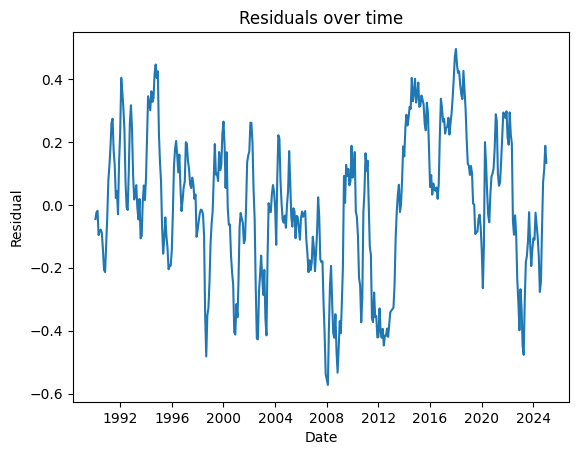





Target variable:  10y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.6530122647305618, 'Rates pc2': -0.23160376816514655} 

R2:  0.9642619365294834 

Residuals pass mean reversion test?  True 



<Figure size 640x480 with 0 Axes>

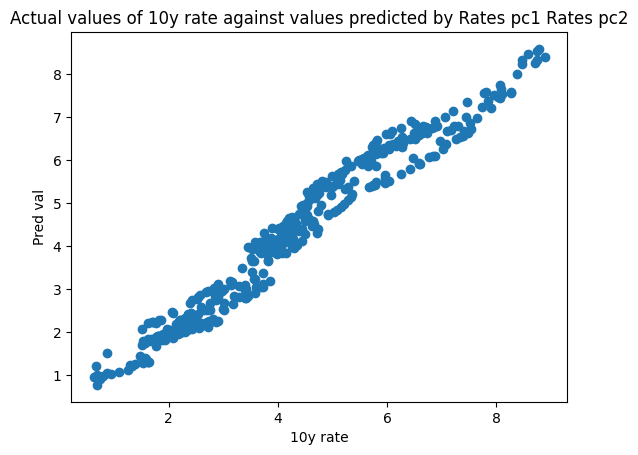

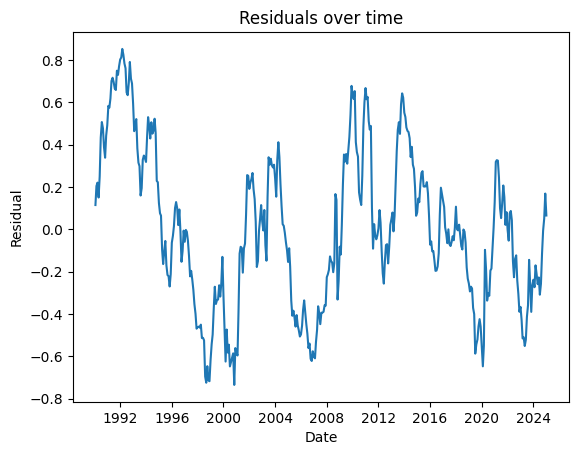





Target variable:  30y rate 

Regressors:  Rates pc1 Rates pc2 

Coefficients:  {'Rates pc1': 0.574064108320928, 'Rates pc2': -0.367144020017042} 

R2:  0.9037720279480386 

Residuals pass mean reversion test?  False 



<Figure size 640x480 with 0 Axes>

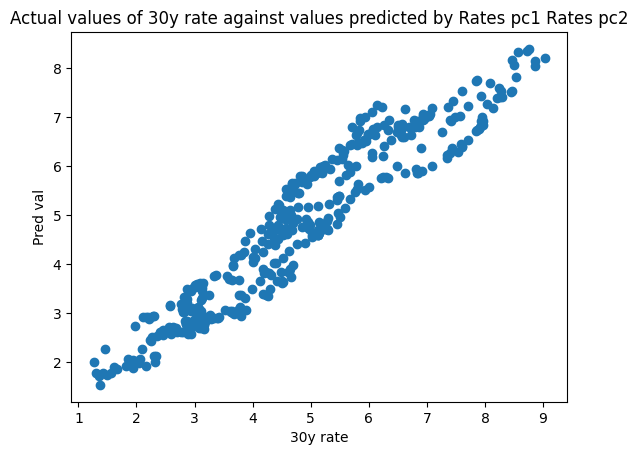

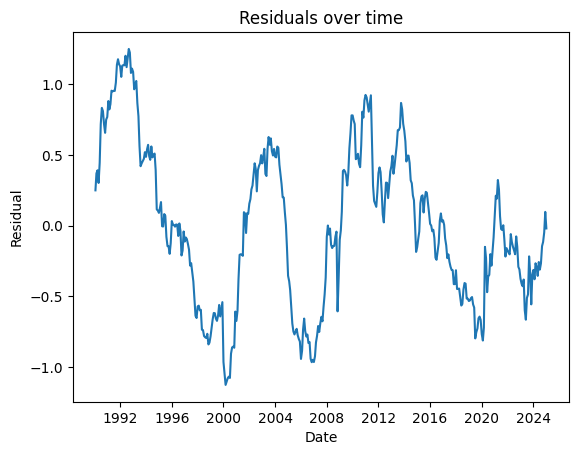

<Figure size 640x480 with 0 Axes>

In [125]:
for series in total_df_long_hist.columns:
  if "pc" in series:
    continue
  group = series_to_group[series]
  regressors = [col for col in total_df_long_hist.columns if "pc" in col and group in col]
  print("\n\n\n")
  calc_and_show_regression(total_df_long_hist[regressors], total_df_long_hist[series])

Now we will pivot to fitting a VECM model on the PCs. First, let's test the order of integration of each PC.



In [126]:
retained_cols = [series for series in total_df_long_hist.columns if "pc" in series]
print("PC factors: ", retained_cols, "\n")
pc_df = total_df_long_hist[retained_cols]

non_stationary_series = []
for series in pc_df.columns:
  if adfuller(pc_df[series][pc_df[series].notna()].values)[1]>0.01:
    non_stationary_series.append(series)



print("I(0) series in dataset: ", [series for series in pc_df.columns if series not in non_stationary_series], "\n")
#print("I(>0) series in dataset: ", non_stationary_series, "\n")

pc_df_first_diff = pc_df[pc_df.notna()].diff(1).dropna()
order_one_series = []
for series in non_stationary_series:
  if adfuller(pc_df_first_diff[series].values)[1]<0.01:
   order_one_series.append(series)

print("I(1) series in dataset: ", order_one_series, "\n")

pc_df_second_diff = pc_df[pc_df.notna()].diff(1).diff(1).dropna()
order_two_series = []
for series in list(set(non_stationary_series)-set(order_one_series)):
  if adfuller(pc_df_second_diff[series].values)[1]<0.01:
    order_two_series.append(series)

print("I(2) series in dataset: ", order_two_series, "\n")
print("I(>2) series in dataset: ", list(set(non_stationary_series)-set(order_one_series)-set(order_two_series)))

PC factors:  ['Housing pc1', 'Housing pc2', 'Prices pc1', 'Prices pc2', 'Prices pc3', 'Prices pc4', 'Prices pc5', 'Rates pc1', 'Rates pc2', 'Unemployment pc1', 'Unemployment pc2'] 

I(0) series in dataset:  ['Prices pc1', 'Prices pc2', 'Prices pc3', 'Prices pc4', 'Prices pc5', 'Unemployment pc1'] 

I(1) series in dataset:  ['Housing pc1', 'Housing pc2', 'Rates pc1', 'Rates pc2', 'Unemployment pc2'] 

I(2) series in dataset:  [] 

I(>2) series in dataset:  []


Look at PACF and spectral density of each PC to get a sense of lag length. Apart from housing pc2, seems like first 2-3 lags are most significant

['Housing pc1', 'Housing pc2', 'Prices pc1', 'Prices pc2', 'Prices pc3', 'Prices pc4', 'Prices pc5', 'Rates pc1', 'Rates pc2', 'Unemployment pc1', 'Unemployment pc2']


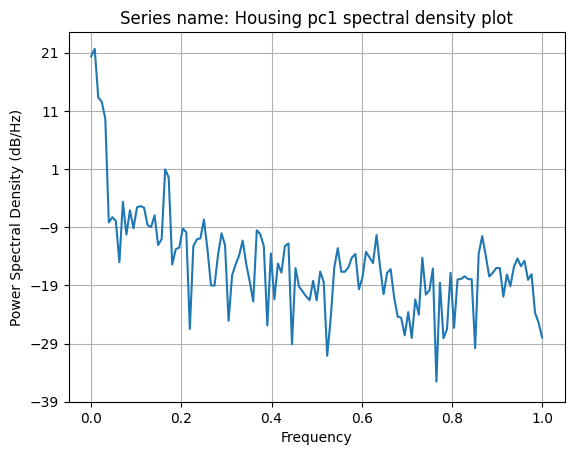

<Figure size 640x480 with 0 Axes>

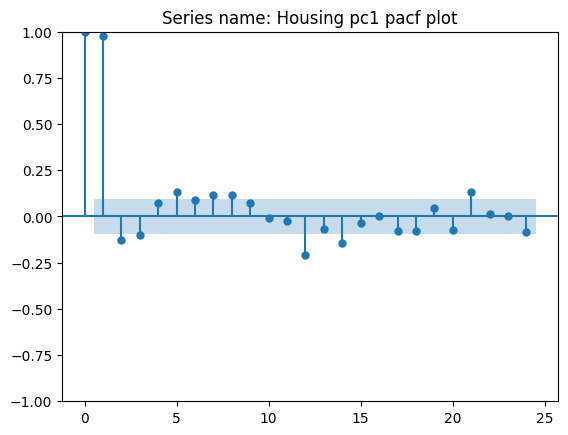

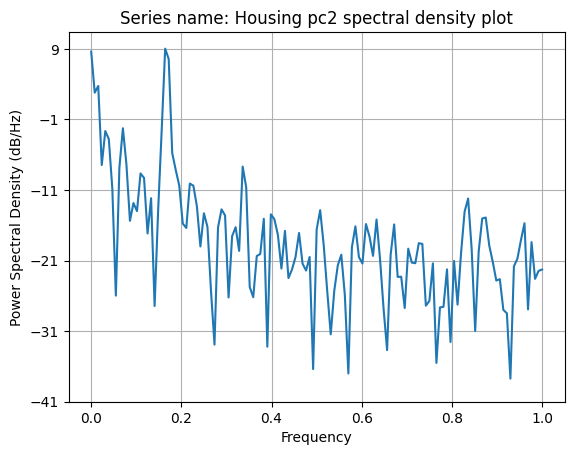

<Figure size 640x480 with 0 Axes>

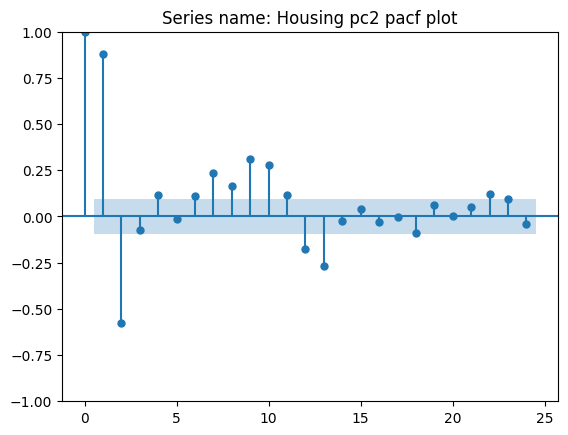

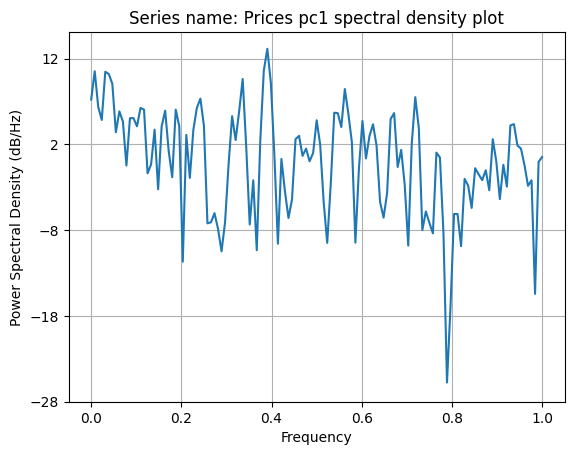

<Figure size 640x480 with 0 Axes>

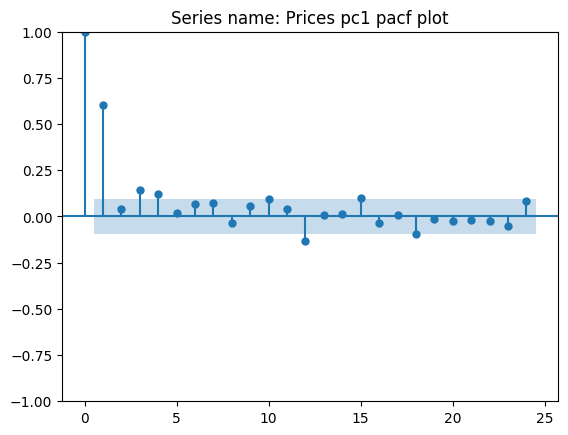

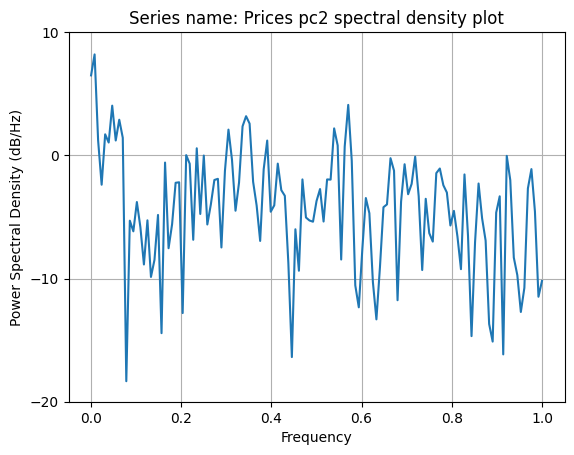

<Figure size 640x480 with 0 Axes>

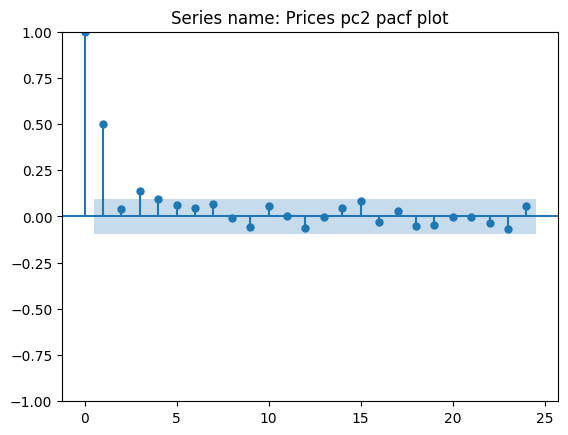

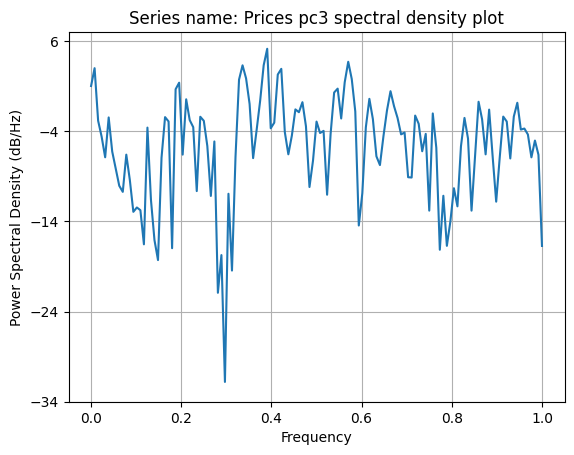

<Figure size 640x480 with 0 Axes>

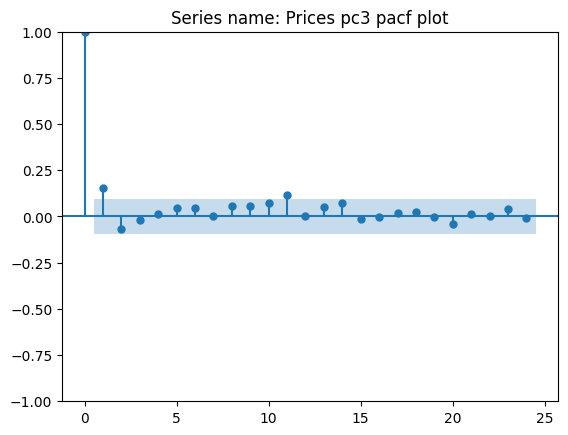

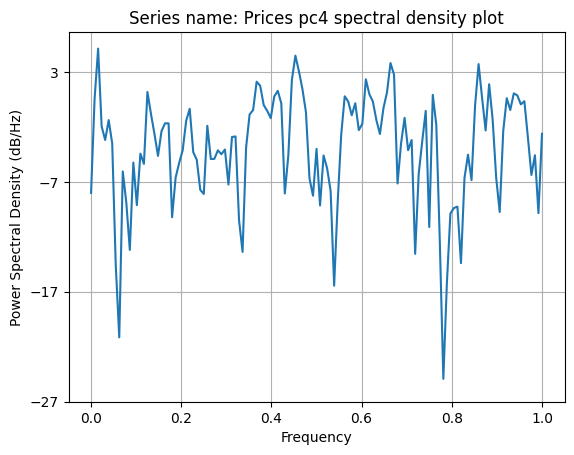

<Figure size 640x480 with 0 Axes>

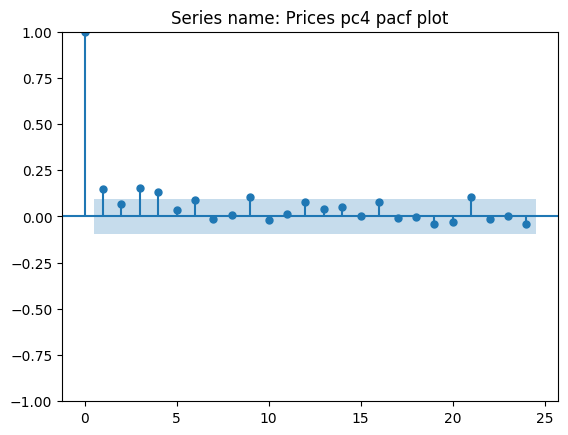

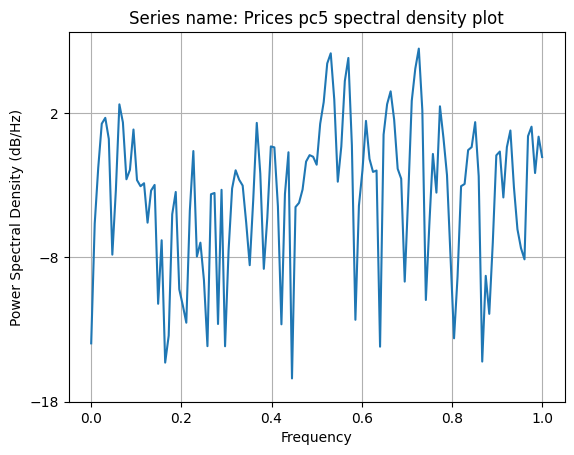

<Figure size 640x480 with 0 Axes>

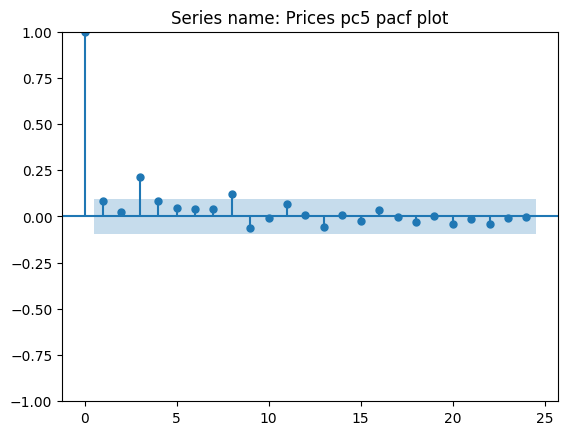

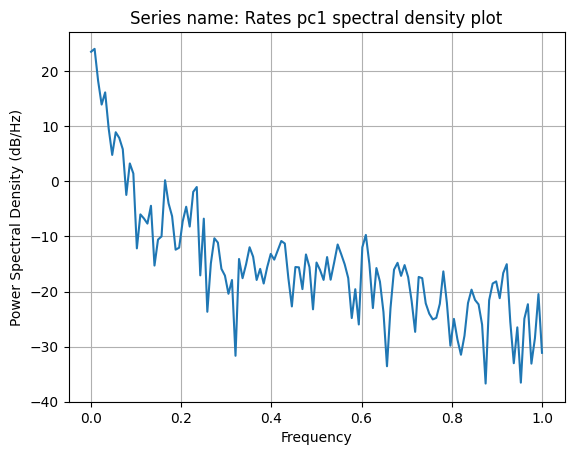

<Figure size 640x480 with 0 Axes>

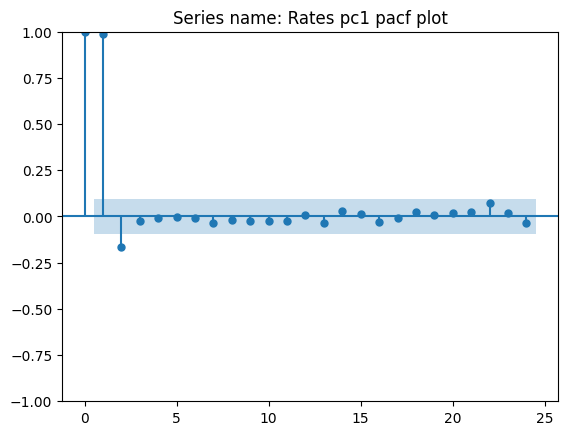

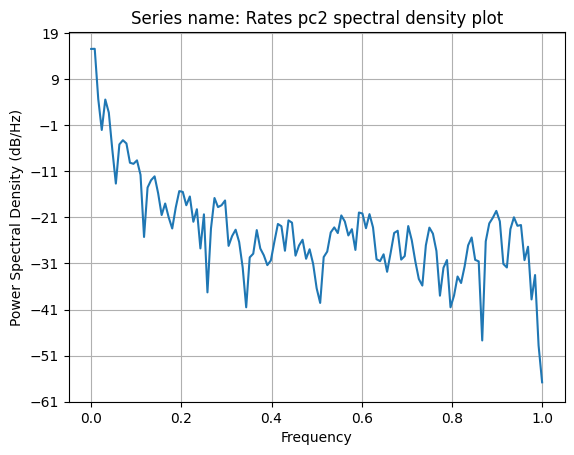

<Figure size 640x480 with 0 Axes>

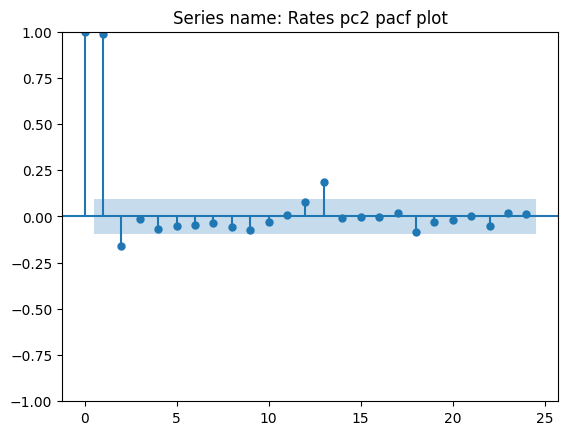

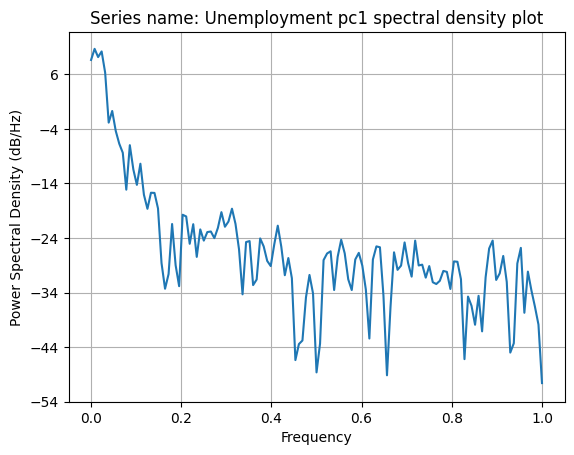

<Figure size 640x480 with 0 Axes>

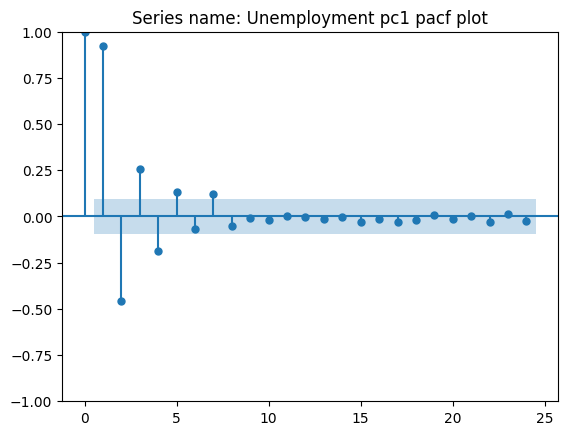

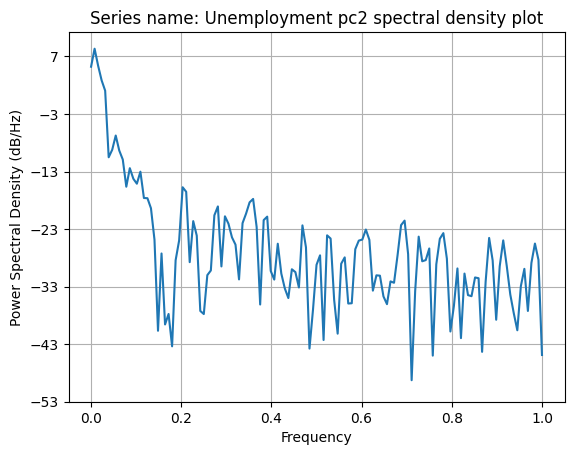

<Figure size 640x480 with 0 Axes>

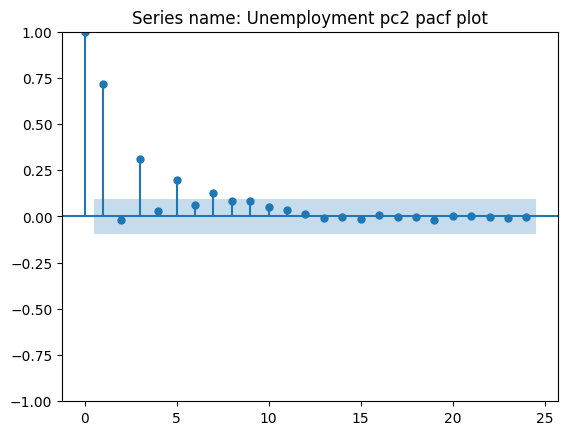

<Figure size 640x480 with 0 Axes>

In [127]:
#now lets try to fit a vecm model on the pcs to make predictions
#look at pacf plots and spectral densities to get a sense of lag length

retained_cols = [series for series in total_df_long_hist.columns if "pc" in series]
print(retained_cols)
pc_df = total_df_long_hist[retained_cols]
for series in pc_df.columns:
  plt.psd(pc_df[series])
  plt.title("Series name: "+ series+ " spectral density plot")
  plt.show()
  plt.clf()
  plot_pacf(pc_df[series], lags=24)
  plt.title("Series name: "+ series+ " pacf plot")
  plt.show()
  plt.clf()


Select lags with information criteria

In [134]:
#PACF profiles decay quickly after first 3-4 lags, but test out to 10
lag_order = select_order(data=pc_df, maxlags=10, deterministic="coci", seasons=0)
lag_order.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

<class 'statsmodels.iolib.table.SimpleTable'>

Determine number of cointegrating relationships using Johansen test with two lags and constant deterministic terms. We find seven relationships among the variables

In [137]:
#determine # of cointegrating relationships
rank_test = select_coint_rank(pc_df, det_order=0, k_ar_diff=lag_order.aic, method="trace", signif=0.05)
rank_test.summary()
print(rank_test.summary())
print(rank_test.rank)

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0  11          948.3          285.1
  1  11          729.7          239.2
  2  11          530.8          197.4
  3  11          377.4          159.5
  4  11          257.7          125.6
  5  11          144.3          95.75
  6  11          79.16          69.82
  7  11          35.99          47.85
-------------------------------------
7


Fit vecm with two lags, seven cointegrating relationships, and constant term inside the cointegration parenthesis

In [138]:
#now we have enough info to fit the VECM model
model = VECM(pc_df, deterministic="ci", seasons=0, k_ar_diff=lag_order.aic, coint_rank=rank_test.rank)
vecm_model = model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Predict the PC factors two years out (24 steps). Then, call inverses of the PCA transform and scaler transform to recover estimated values of the  variables in our original space. The PCA loses some variance, so the inversion isn't one to one.

In [141]:
#Make predictions out to 2 years

pred_vals = vecm_model.predict(steps = 24)
pred_indices = [pc_df.index[-1].date()+relativedelta(months=k+1) for k in range(24)]
pred_df = pd.DataFrame(index = pred_indices, columns = pc_df.columns, data = pred_vals)
pred_df[pca_component_dict["Rates"].columns] = scaler_dict["Rates"].inverse_transform(pca_object_dict["Rates"].inverse_transform(pred_df[[series for series in pred_df.columns if "Rates" in series]]))
pred_df[pca_component_dict["Housing"].columns] = scaler_dict["Housing"].inverse_transform(pca_object_dict["Housing"].inverse_transform(pred_df[[series for series in pred_df.columns if "Housing" in series]]))
pred_df[pca_component_dict["Prices"].columns] = scaler_dict["Prices"].inverse_transform(pca_object_dict["Prices"].inverse_transform(pred_df[[series for series in pred_df.columns if "Prices" in series]]))
pred_df[pca_component_dict["Unemployment"].columns] = scaler_dict["Unemployment"].inverse_transform(pca_object_dict["Unemployment"].inverse_transform(pred_df[[series for series in pred_df.columns if "Unemployment" in series]]))

extended_df = pd.concat([total_df_long_hist, pred_df], axis=0)


Plot our forecasts side-by-side with the actual data from the last two years. Notice that for some variables, there is discontinuity at 01/01/2025 as we switch from actual values to predicted values. It requires some proof, but these variables are likely sacrificed by the PCA, so our predictions of the PCs tell us very little about these variables.

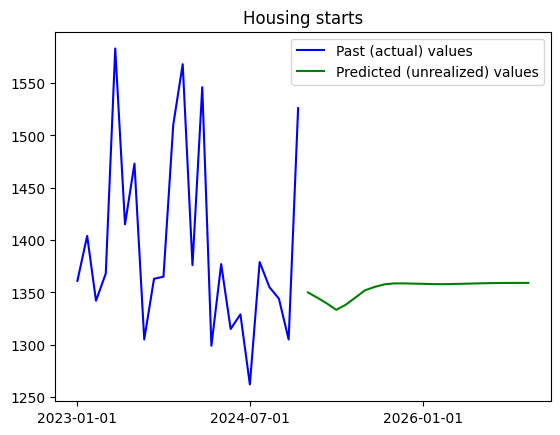

<Figure size 640x480 with 0 Axes>

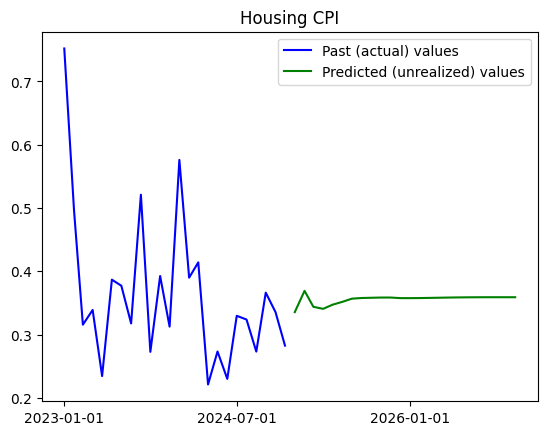

<Figure size 640x480 with 0 Axes>

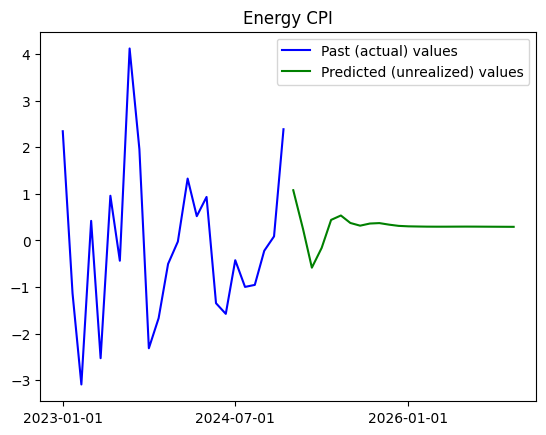

<Figure size 640x480 with 0 Axes>

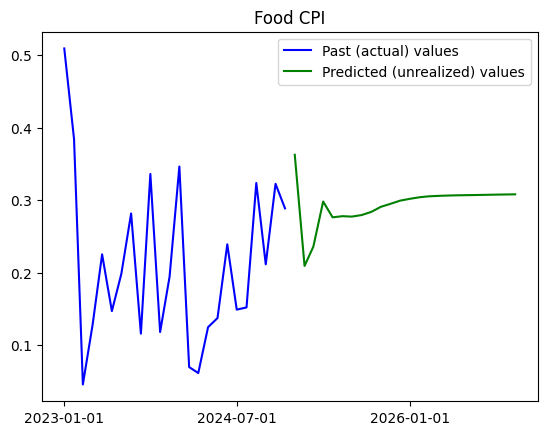

<Figure size 640x480 with 0 Axes>

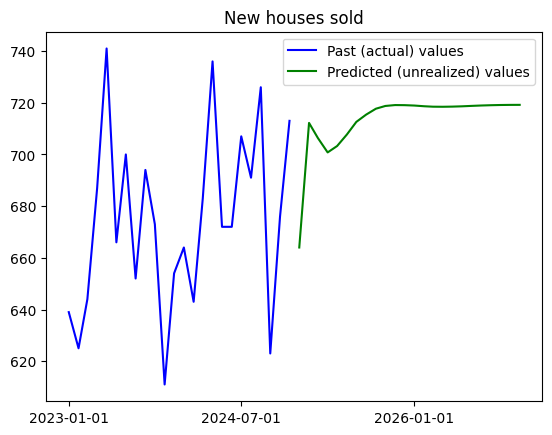

<Figure size 640x480 with 0 Axes>

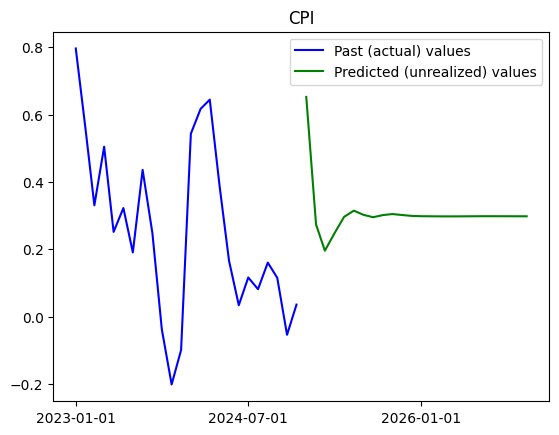

<Figure size 640x480 with 0 Axes>

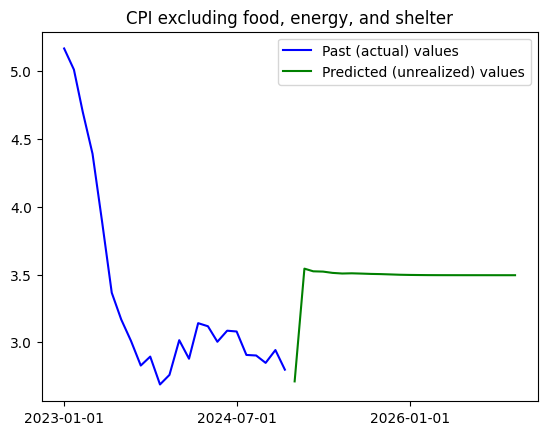

<Figure size 640x480 with 0 Axes>

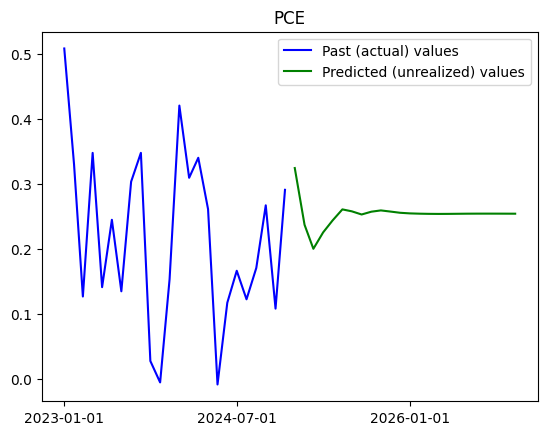

<Figure size 640x480 with 0 Axes>

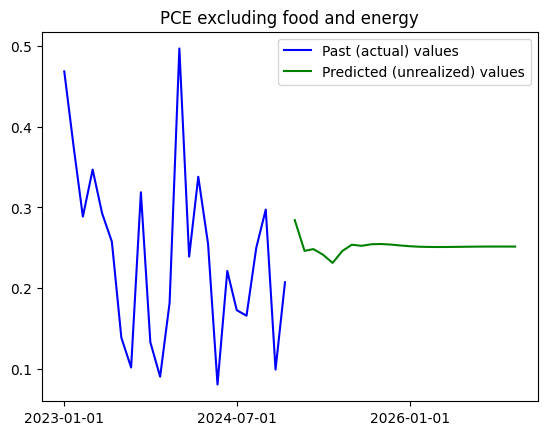

<Figure size 640x480 with 0 Axes>

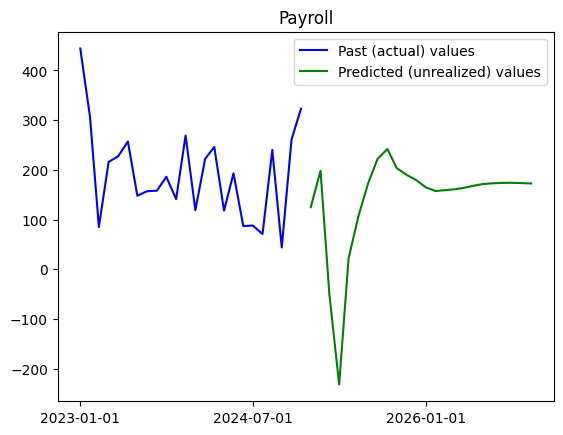

<Figure size 640x480 with 0 Axes>

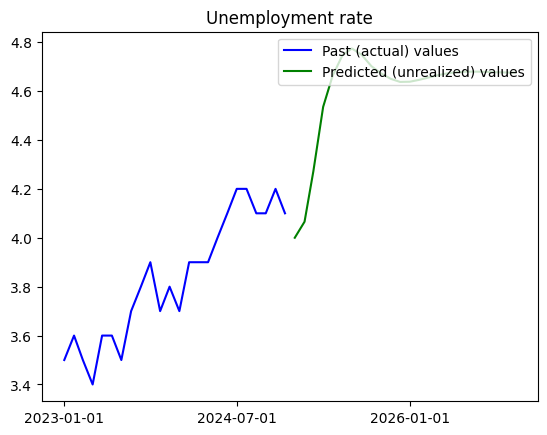

<Figure size 640x480 with 0 Axes>

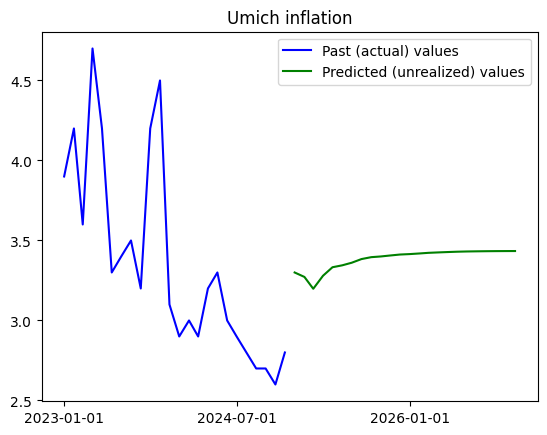

<Figure size 640x480 with 0 Axes>

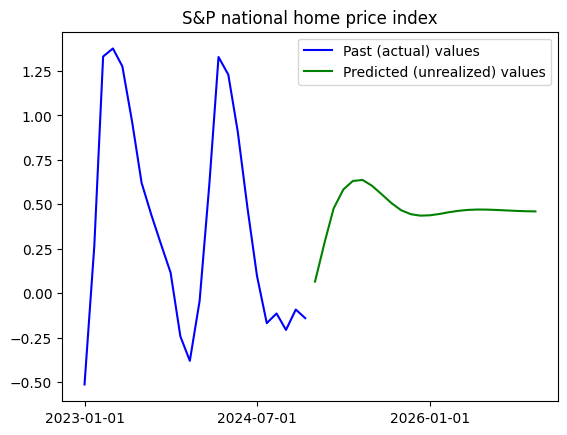

<Figure size 640x480 with 0 Axes>

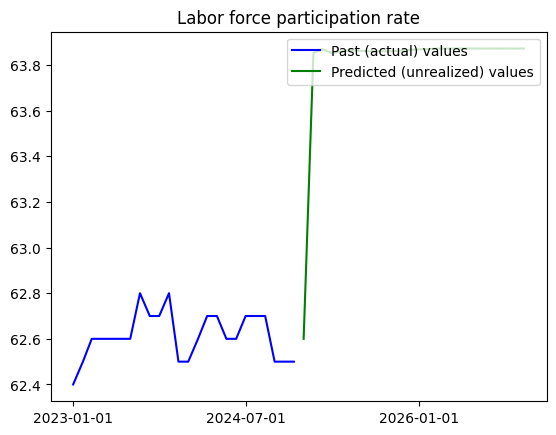

<Figure size 640x480 with 0 Axes>

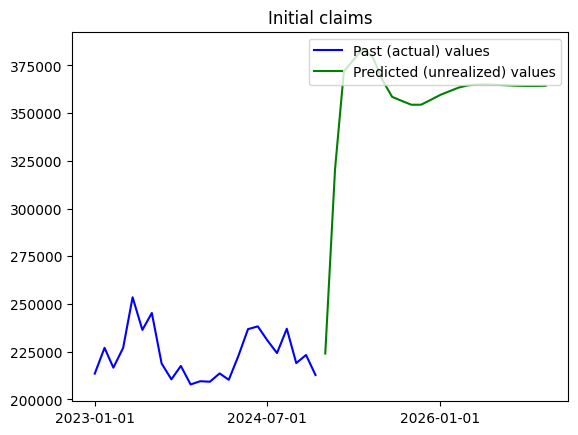

<Figure size 640x480 with 0 Axes>

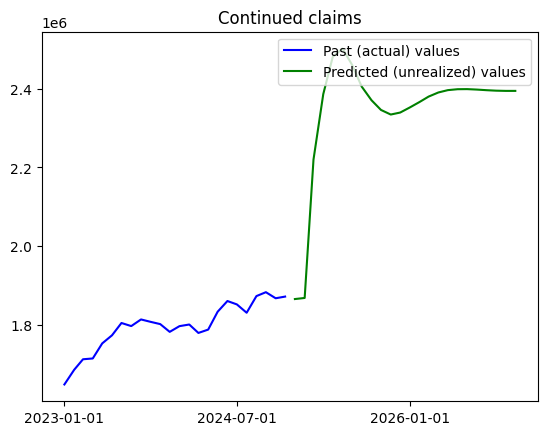

<Figure size 640x480 with 0 Axes>

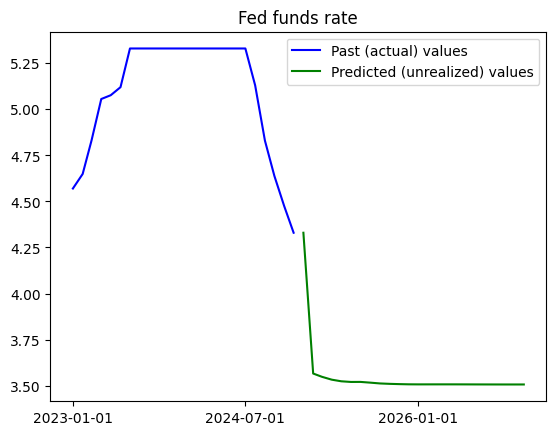

<Figure size 640x480 with 0 Axes>

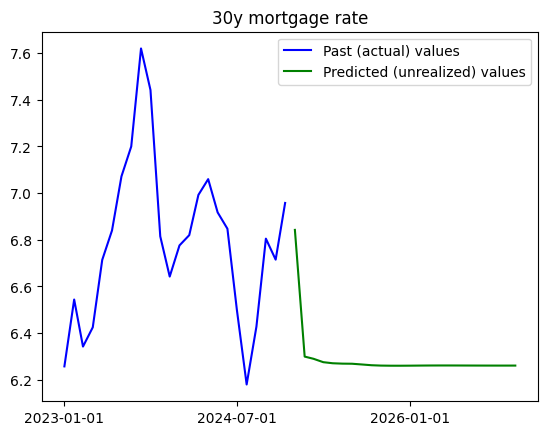

<Figure size 640x480 with 0 Axes>

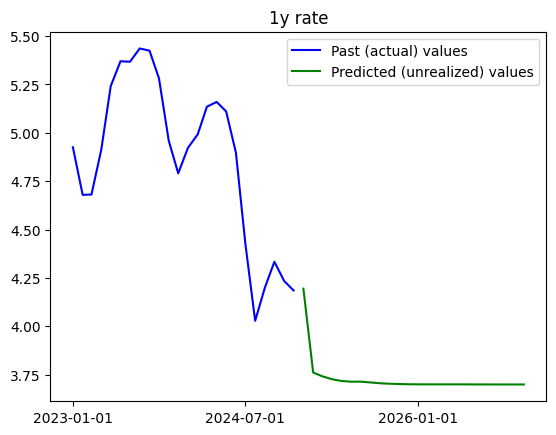

<Figure size 640x480 with 0 Axes>

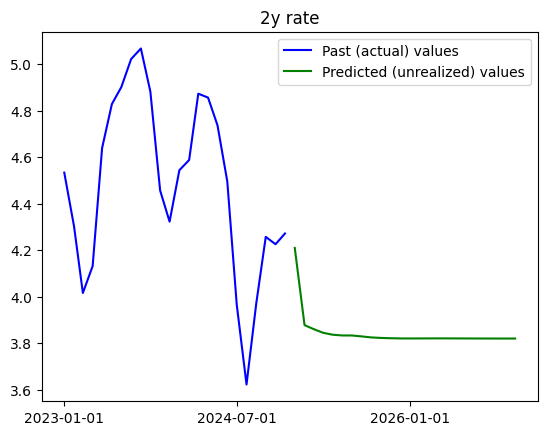

<Figure size 640x480 with 0 Axes>

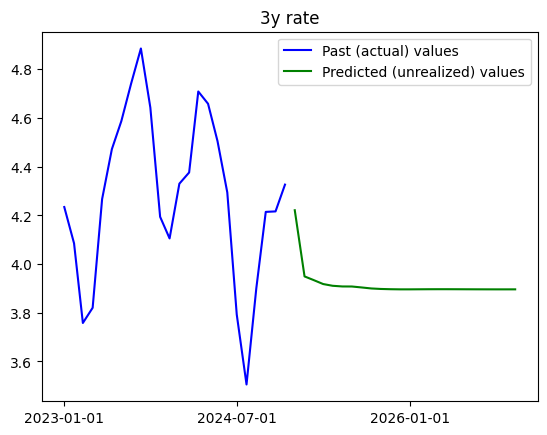

<Figure size 640x480 with 0 Axes>

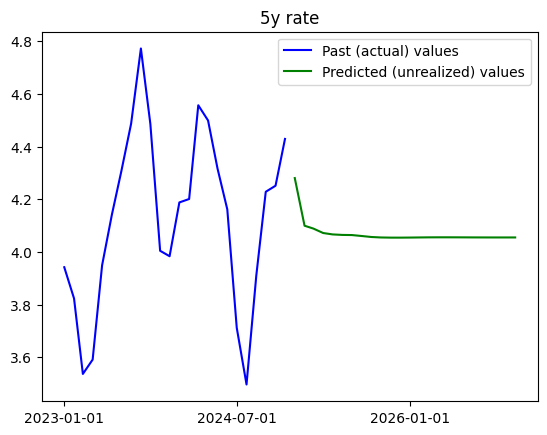

<Figure size 640x480 with 0 Axes>

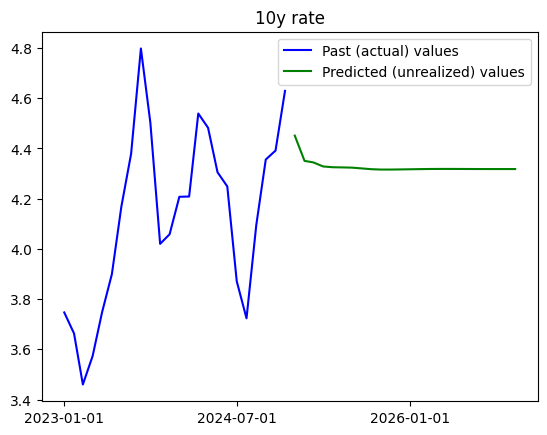

<Figure size 640x480 with 0 Axes>

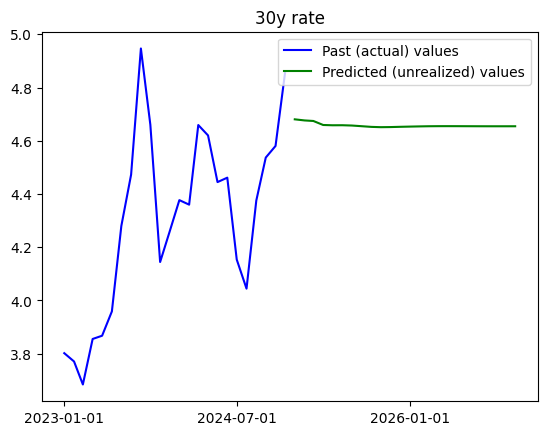

<Figure size 640x480 with 0 Axes>

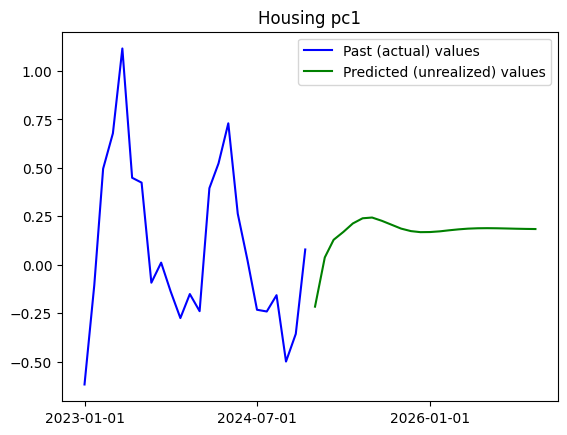

<Figure size 640x480 with 0 Axes>

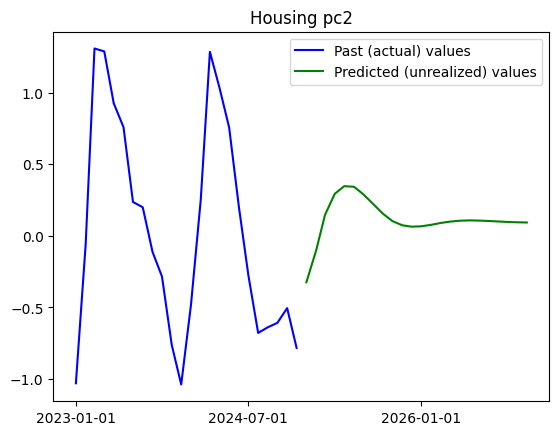

<Figure size 640x480 with 0 Axes>

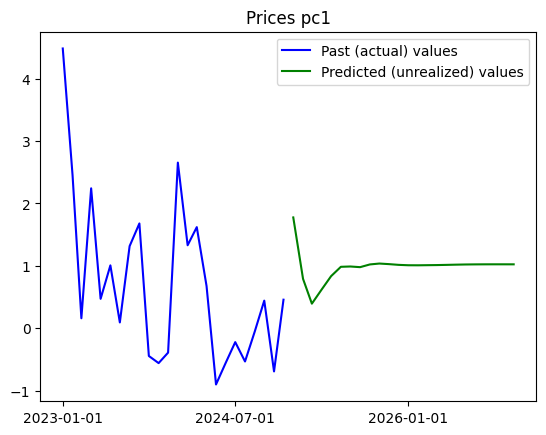

<Figure size 640x480 with 0 Axes>

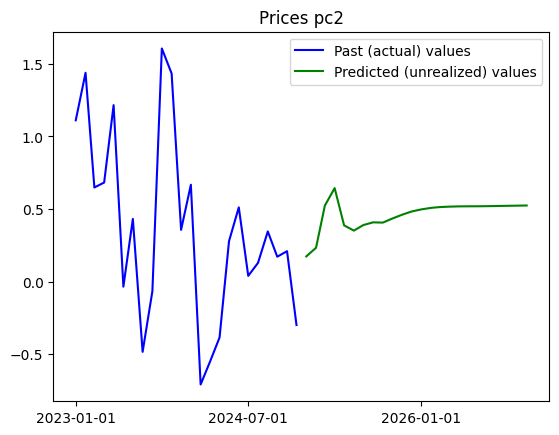

<Figure size 640x480 with 0 Axes>

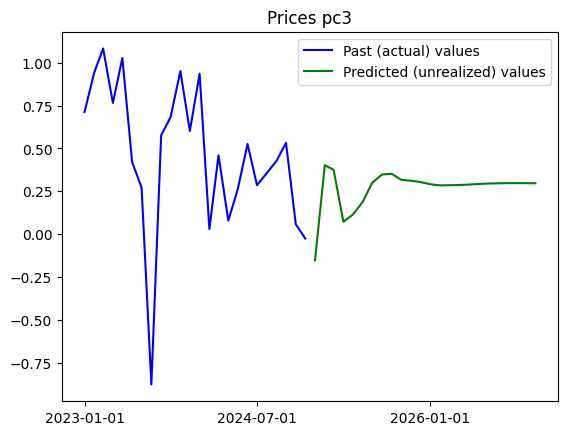

<Figure size 640x480 with 0 Axes>

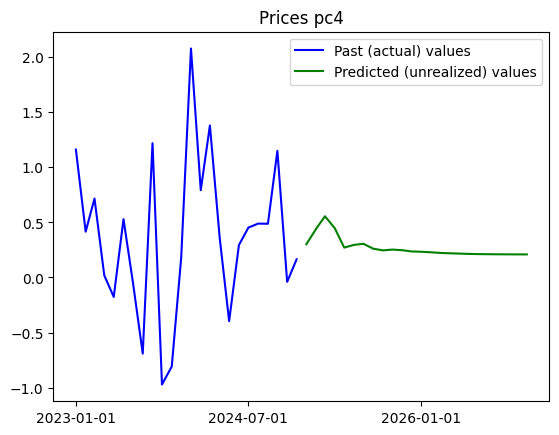

<Figure size 640x480 with 0 Axes>

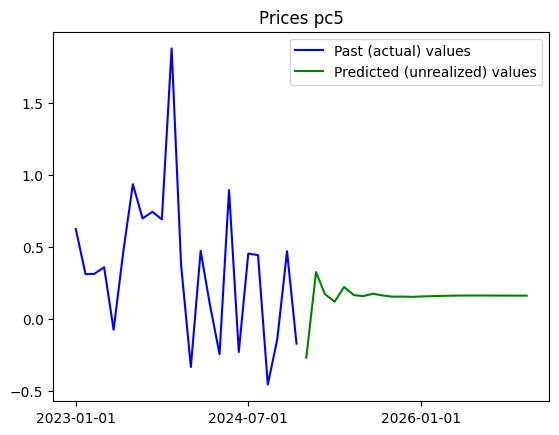

<Figure size 640x480 with 0 Axes>

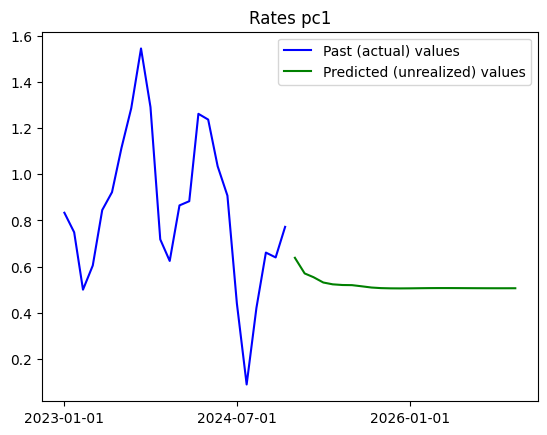

<Figure size 640x480 with 0 Axes>

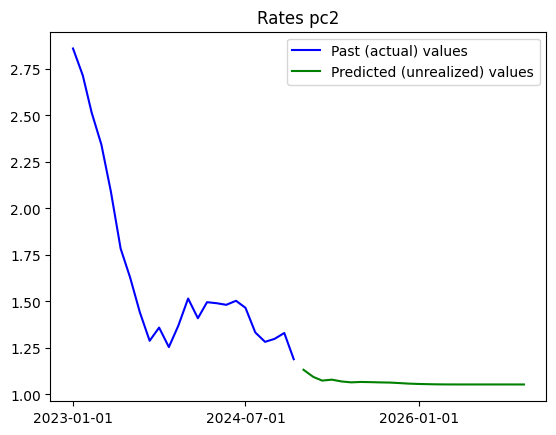

<Figure size 640x480 with 0 Axes>

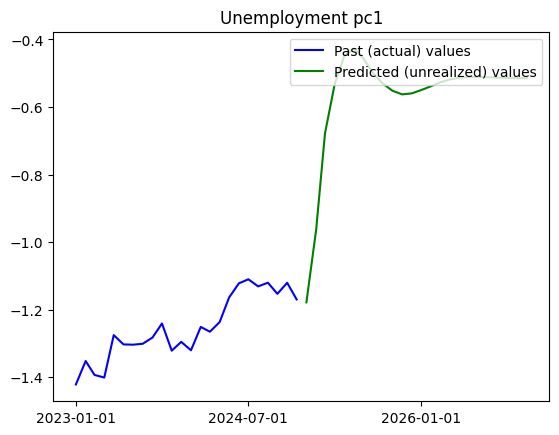

<Figure size 640x480 with 0 Axes>

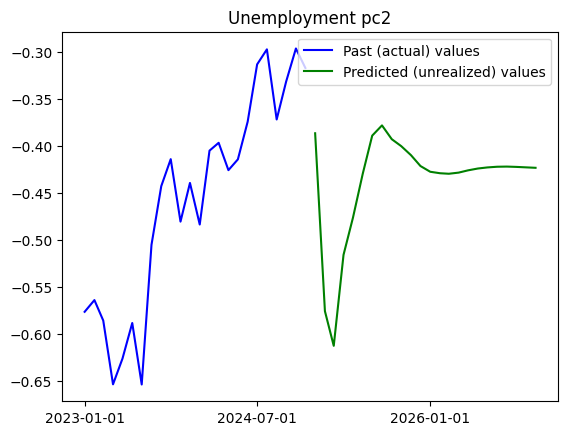

<Figure size 640x480 with 0 Axes>

In [142]:
#plot last two years of real data next to our forecasts two years out
for series in extended_df.columns:
  fig, ax = plt.subplots()
  l1 = ax.plot(extended_df[series].loc[filter(lambda x: 2023<=x.year<=2024, extended_df.index)], color = "blue")[0]
  l2 = ax.plot(extended_df[series].loc[filter(lambda x: 2025<=x.year<=2026, extended_df.index)], color = "green")[0]
  ax.set_title(series)
  ax.legend((l1, l2), ("Past (actual) values", "Predicted (unrealized) values"), loc="upper right")
  ax.set_xticks(ax.get_xticks()[::len(ax.get_xticks())//3])
  plt.show()
  plt.clf()

Prediction summary: 25-50 bp rally in rates, mild curve steepening, Fed cuts to mid 3% range, sticky/slightly hot inflation, sudden lurch higher in jobless claims with unemployment stablizing in the high 4% range.


Why we should be skeptical: distinct historical regimes (such as the 2020-2022 COVID period) have fewer than 30 data points with 11 latent variables, due to the monthly frequency of the series. More philosophically, the economy is a highly nonlinear and chaotic system that likely defies stable cointegration relationships. VECM may be fitting the trends in the series (so teasing out lower rates, stubborn inflation, higher unemployment) without providing differentiated predictions.

